# Loading general libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import networkx as nx
import re
import random
from gprofiler import GProfiler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score, 
    normalized_mutual_info_score
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
import scipy.cluster.hierarchy as sch
from matplotlib_venn import venn2, venn3
from pandas.plotting import parallel_coordinates
from collections import defaultdict
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import heapq
import xgboost as xgb
from itertools import chain
from upsetplot import from_contents, plot
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth

# Functions

## Functions for Hierarchical clustering

In [2]:

def apply_pca(X, n_components=10):
    pca = PCA(n_components=n_components)
    pca_fit = pca.fit(X)
    explained_variance = pca.explained_variance_ratio_

    return pca_fit,explained_variance, pca.transform(X), pca.components_


def hierarchical_clustering(pca_df):

    X = pca_df.to_numpy()
    n_samples = X.shape[0]
    distance_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            distance_matrix[i, j] = np.linalg.norm([X[i], X[j]])
            distance_matrix[j, i] = distance_matrix[i, j]

    linkage_matrix = linkage(X, method='ward', metric='euclidean')

    return n_samples, linkage_matrix


def pca_analisis(pcn, df_clust, n_component = 0):

    #pc1 = pcn[n_component]
    smallest_values_with_indices = heapq.nsmallest(10, enumerate(pcn[n_component]), key=lambda x: x[1])
    smallest_values = [x[1] for x in smallest_values_with_indices]
    smallest_indices = [x[0] for x in smallest_values_with_indices]

    print(f'Most important variables for the negative direction on pc{n_component+1}')
    print(df_clust.iloc[:, smallest_indices].columns)

    largest_values_with_indices = heapq.nlargest(10, enumerate(pcn[n_component]), key=lambda x: x[1])
    largest_values = [x[1] for x in largest_values_with_indices]
    largest_indices = [x[0] for x in largest_values_with_indices]

    print(f'Most important variables for the positive direction on pc{n_component+1}')
    print(df_clust.iloc[:, largest_indices].columns)

def pca_ranking(df_clust, loadings, top_k = None):
    # Example dataset feature names
    features = df_clust.columns

    # Loadings matrix (rows = PCs, columns = features)
    #loadings = pca.components_

    # Specify the number of top features to extract
    if top_k == None:
        top_k = loadings.shape[1]

    # Find top features for each component
    top_features_per_pc = {}

    for i, pc in enumerate(loadings):
        # Get absolute loadings and sort by importance
        sorted_indices = np.argsort(np.abs(pc))[::-1][:top_k]  # Top-k largest (absolute) loadings
        top_features_per_pc[f'PC{i+1}'] = features[sorted_indices]

    # Convert to a DataFrame for better visualization
    top_features_df = pd.DataFrame(top_features_per_pc)

    top_features_df.to_csv("../data/pca_top_features.csv")


## Plots

def plot_scree(pca_fit):
    PC_values = np.arange(pca_fit.n_components_) + 1
    plt.figure(figsize=(8, 6))
    plt.plot(PC_values, pca_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.grid()
    plt.savefig("../results/hierarchical_clustering/var_explained_pca10.png")



def plot_dendogram(n_samples, linkage_matrix):

    plt.figure(figsize=(20, 6))
    sch.dendrogram(linkage_matrix, labels=[f"Point {i}" for i in range(n_samples)])
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.grid()
    plt.savefig("../results/hierarchical_clustering/hierarchichal_dendogram.png")

def plot_cluster_results(pca_df, linkage_matrix, num_clusters = 6 ):

    X = pca_df.to_numpy()
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.title("Hierarchical Clustering Results (Scatter Plot)")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.colorbar(label="Cluster")
    plt.grid()
    plt.savefig("../results/hierarchical_clustering/pca_cluster_results.png")

    return X, cluster_labels

def plot_knn(df_pca, k = 5): # reduced pca dataset
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors.fit(df_pca)  # Use your PCA-reduced dataset
    distances, _ = nearest_neighbors.kneighbors(df_pca)

    # Sort distances and plot the k-distance graph
    distances = np.sort(distances[:, k - 1])  # k-th nearest neighbor distances
    # Improved visualization
    plt.figure(figsize=(10, 6))
    plt.plot(distances, color='blue', linewidth=2, label=f'{k}-Distance')
    plt.title('k-Distance Graph', fontsize=16, fontweight='bold')
    plt.xlabel('Data Points (sorted by distance)', fontsize=14)
    plt.ylabel(f'{k}-Distance', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(y=np.mean(distances), color='red', linestyle='--', linewidth=1.5, label='Mean Distance')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("DBSCAN_1.png", dpi=300, bbox_inches='tight')
    plt.show()



# DBSCAN

In [3]:
df = pd.read_csv('../data/CIT_full.csv')
df_classes = pd.read_csv('../data/CIT_classes.csv')

In [4]:
df_gene_expression = df.transpose()

# Set the first row as the index

df_gene_expression.columns = df_gene_expression.iloc[0]  # Set the first row as column headers
df_transposed = df_gene_expression.drop(df_gene_expression.index[0]) 
df_classes=df_classes.rename(columns={"Unnamed: 0	":"sample_id","x":"target"})
df_transposed=df_transposed.rename(columns={"Unnamed: 0	":"sample_id"})



In [5]:
# Merge expression data and class labels
df = df_transposed.merge(df_classes, left_index=True, right_on='Unnamed: 0')

# Define the feature columns and target column
X = df.drop(['Unnamed: 0', 'target'], axis=1)  # Features (expression data)
y = df['target']  # Target labels

# Perform the stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Check the class distribution in train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
target
normL    0.245847
lumB     0.186047
lumA     0.172757
basL     0.149502
lumC     0.136213
mApo     0.109635
Name: proportion, dtype: float64
Test set class distribution:
target
normL    0.259259
lumB     0.185185
lumA     0.166667
basL     0.148148
lumC     0.129630
mApo     0.111111
Name: proportion, dtype: float64


# Dimensionality Reduction - Using PCA
## PCA - Initial Model
#### Data Scaling and Dimensionality Reduction
- Uses `StandardScaler` to normalize the data so that features have a mean of 0 and standard deviation of 1.
- Normalization ensures that no single feature dominates PCA or clustering due to scale differences.


In [6]:
# Assuming `X` is your dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the scaled data
print("Scaled Data Shape:", X_scaled.shape)

Scaled Data Shape: (355, 20824)


#### Explained Variance Ratio and Scree Plot
Computes the top 10 components and calculates the variance explained by each.

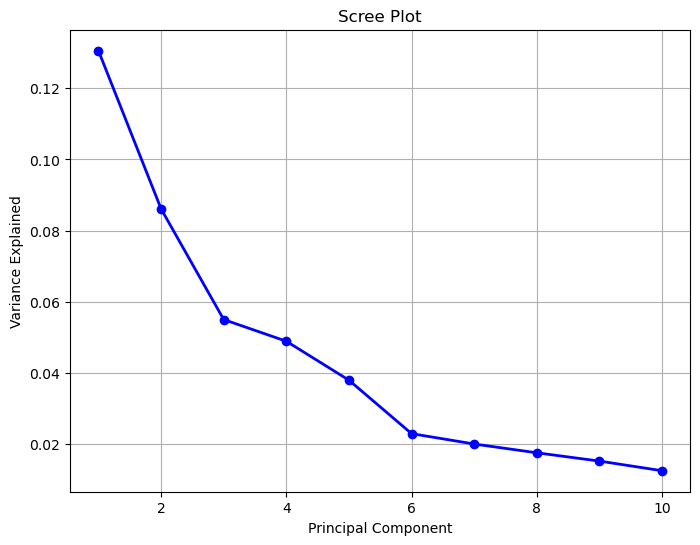

In [7]:
pca_fit, _, _, _  = apply_pca(X_scaled, n_components = 10)
plot_scree(pca_fit = pca_fit)

In [8]:
# Initialize an empty list to store explained variance for each number of components
explained_variances = []

# Loop through the number of components from 2 to 10
for n_components in range(2, 11):
    # Perform PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate the cumulative explained variance ratio
    explained_variance = pca.explained_variance_ratio_.sum()
    explained_variances.append((n_components, explained_variance))
    print(f"Number of Components: {n_components}, Explained Variance Retained: {explained_variance:.2f}")

# Convert the results to a numpy array for easier visualization if needed
explained_variances = np.array(explained_variances)

Number of Components: 2, Explained Variance Retained: 0.22
Number of Components: 3, Explained Variance Retained: 0.27
Number of Components: 4, Explained Variance Retained: 0.32
Number of Components: 5, Explained Variance Retained: 0.36
Number of Components: 6, Explained Variance Retained: 0.38
Number of Components: 7, Explained Variance Retained: 0.40
Number of Components: 8, Explained Variance Retained: 0.42
Number of Components: 9, Explained Variance Retained: 0.43
Number of Components: 10, Explained Variance Retained: 0.45


In [9]:
pca = PCA()
pca.fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)  # Choose the number of components that retains ~80% variance


[0.13057615 0.2166956  0.27169962 0.32060836 0.35856583 0.38150048
 0.40151902 0.41907014 0.43429069 0.44680356 0.45716948 0.46723698
 0.47603055 0.48446637 0.4924384  0.49970901 0.5067739  0.51348584
 0.51977814 0.52570385 0.53154566 0.53729963 0.54271006 0.54792338
 0.55298704 0.55779712 0.56249037 0.5671093  0.57153463 0.57587972
 0.58006941 0.58418997 0.58824302 0.59220512 0.59605833 0.59974735
 0.60340846 0.60703697 0.61056326 0.61401777 0.61741567 0.62076749
 0.62403554 0.6272406  0.63035948 0.63344045 0.63646592 0.63946913
 0.64239313 0.64530688 0.64817875 0.65103262 0.65385519 0.65664677
 0.65938942 0.6620979  0.66478429 0.66744178 0.67007892 0.67267097
 0.67522519 0.677746   0.68019517 0.6826329  0.68505345 0.68743824
 0.68979985 0.69213194 0.69445519 0.69676356 0.69900268 0.70123209
 0.7034415  0.70562892 0.70777185 0.70990857 0.71202368 0.71410926
 0.71618906 0.71823021 0.72024329 0.72224251 0.72422811 0.72619482
 0.72814177 0.73006904 0.73198567 0.73389284 0.7357937  0.7376

#### Applying PCA=3 on the scaled dataset

In [10]:
pca = PCA(n_components=3)  # Adjust based on cumulative variance
X_pca = pca.fit_transform(X_scaled)

#### Parameter Selection Using k-Distance Graph

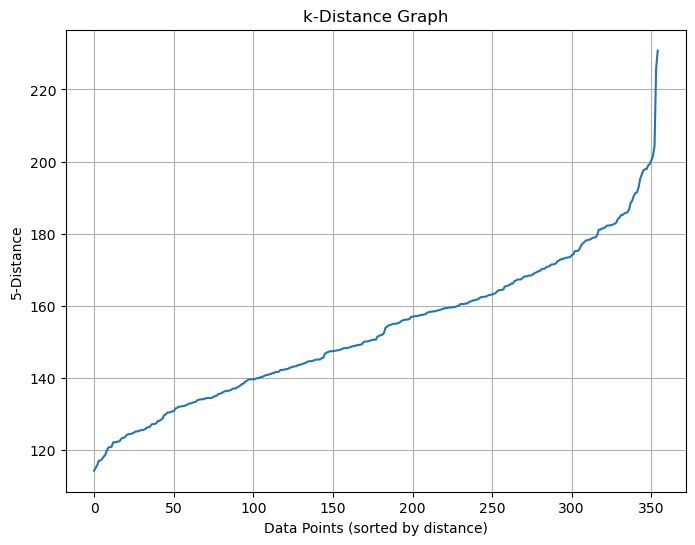

In [11]:
k = 5  # Typically, k = min_samples - 1
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(X_scaled)
distances, _ = nearest_neighbors.kneighbors(X_scaled)

# Sort and plot distances
distances = np.sort(distances[:, k - 1])
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('k-Distance Graph')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'{k}-Distance')
plt.grid()
plt.show()


#### Grid Search for Optimal Parameters

In [12]:
# Define a range of values for eps (based on the k-distance graph) and min_samples
eps_values = np.arange(180, 210, 5)  # Adjust based on your graph
min_samples_values = range(3, 10)  # Reasonable range for min_samples

best_eps = None
best_min_samples = None
best_score = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Skip if only one cluster is formed
        if len(set(labels)) <= 1:
            continue
        
        # Calculate silhouette score
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_eps = eps
            best_min_samples = min_samples
            best_score = score

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score:.3f}")

Best eps: 205, Best min_samples: 3, Best Silhouette Score: 0.271


#### Visualizing the clusters

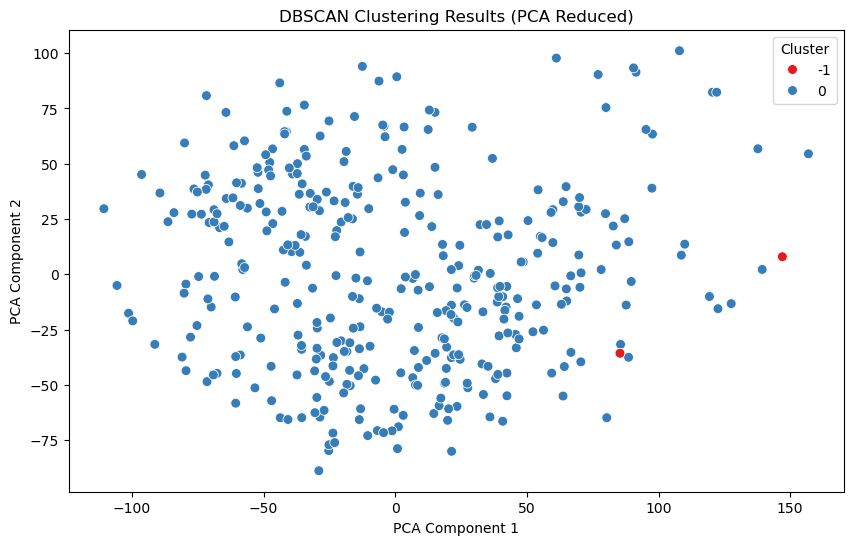

Cluster counts: {-1: 2, 0: 353}


In [13]:
# Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(X_scaled)

# Visualize clusters in PCA-reduced space
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='Set1', s=50)
plt.title('DBSCAN Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.savefig("DBSCAN_3.png", dpi=300, bbox_inches='tight')
plt.show()

# Print cluster counts
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Cluster counts: {dict(zip(unique_labels, counts))}")

In [14]:
# Compute Silhouette Score and Davies-Bouldin Index
if len(set(labels)) > 1:  # Ensure there is more than one cluster
    sil_score = silhouette_score(X_scaled, labels)  # Silhouette Score
    db_score = davies_bouldin_score(X_scaled, labels)  # Davies-Bouldin Index
    
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")
else:
    print("Silhouette Score and Davies-Bouldin Index cannot be calculated with only one cluster.")

Silhouette Score: 0.271
Davies-Bouldin Index: 1.662


### Summary of PCA- Inital Model 

#### **Clustering Results**
- Clustering was performed using DBSCAN on the PCA-reduced dataset (with three components).
- **Silhouette Score**:
0.271

 - The score indicates **moderate clustering quality**, suggesting that the clusters are not well-separated.
- **Number of Clusters**:
- The DBSCAN algorithm identified a small number of clusters, with some data points labeled as noise (`-1`).

#### **Analysis**
- PCA retained 27.17% of the total variance, the clustering results were **moderate at best**.
- The moderate silhouette score and the small number of clusters indicate that the reduced dimensionality (three components) might not sufficiently capture the underlying structure of the data.


## PCA - With Feature Selection

In [15]:
df = pd.read_csv('../data/CIT_full.csv')
df_classes = pd.read_csv('../data/CIT_classes.csv')

In [16]:
df_gene_expression = df.transpose()
# Step 2: Set the first row as the index
df_gene_expression.columns = df_gene_expression.iloc[0]  # Set the first row as column headers
df_transposed = df_gene_expression.drop(df_gene_expression.index[0]) 
df_classes=df_classes.rename(columns={"Unnamed: 0	":"sample_id","x":"target"})
df_transposed=df_transposed.rename(columns={"Unnamed: 0	":"sample_id"})

In [17]:
# Merge expression data and class labels
df = df_transposed.merge(df_classes, left_index=True, right_on='Unnamed: 0')

# Define the feature columns and target column
X = df.drop(['Unnamed: 0', 'target'], axis=1)  # Features (expression data)
y = df['target']  # Target labels

# Perform the stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Check the class distribution in train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
target
normL    0.245847
lumB     0.186047
lumA     0.172757
basL     0.149502
lumC     0.136213
mApo     0.109635
Name: proportion, dtype: float64
Test set class distribution:
target
normL    0.259259
lumB     0.185185
lumA     0.166667
basL     0.148148
lumC     0.129630
mApo     0.111111
Name: proportion, dtype: float64


#### Data Scaling

In [18]:
# Assuming X is your feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features


#### Selecting the 50 most relevant fetures
Recursive Feature Elimination  `SelectKBest` with `mutual_info_classif`

Selects features based on their **mutual information** with the target variable, which is ideal for datasets with non-linear relationships (common in gene expression data).
- By setting `k=50`, you can select the most relevant 50 features out of 20,826.

In [19]:
# Select top 50 features based on mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=50)
X_selected = selector.fit_transform(X_scaled, y) 

#### Scree Plot for Selected Features
Performs PCA on the reduced dataset to calculate variance explained by each component.

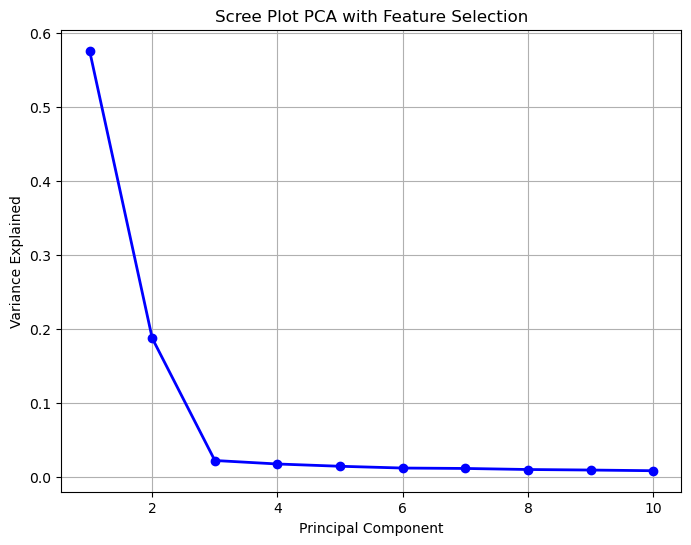

Explained variance ratio: 
[0.57613869 0.18734054 0.02189848 0.01718552 0.0140982  0.01169916
 0.01113624 0.00971958 0.00899955 0.00807287]


In [20]:
# Assuming X_selected is your dataset after feature selection for Model 2
# Apply PCA
pca = PCA(n_components=10)  # You can adjust the number of components based on your analysis
pca_fit = pca.fit(X_selected)

# Create the scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(8, 6))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot PCA with Feature Selection')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid()
plt.show()

# Print explained variance ratio for each component
print('Explained variance ratio: ')
print(pca.explained_variance_ratio_)


#### Comapring PCA =3 and PCA=4 on reduced dataset 

##### PCA=3

In [21]:
# Reduce dimensions to retain sufficient variance
pca = PCA(n_components=3)  # Adjust based on explained variance
X_pca = pca.fit_transform(X_selected)

# Check the retained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance Retained: {explained_variance:.2f}")


Explained Variance Retained: 0.79


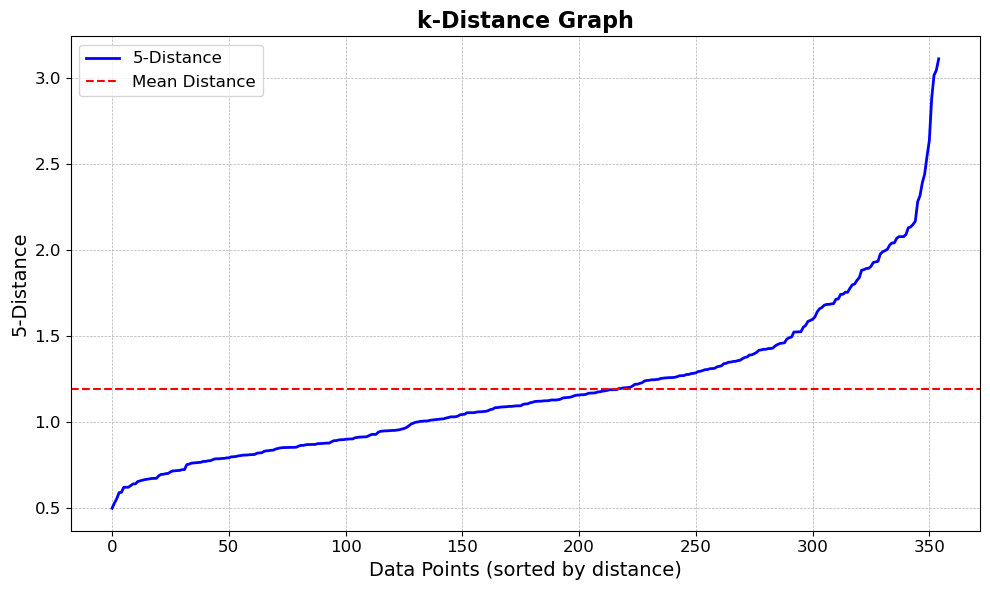

In [22]:
plot_knn(X_pca, k = 5)

In [23]:
# Define the PCA-reduced dataset for Model 2
# Assuming X_pca is already defined (from your PCA step for Model 2)

# Define ranges for eps and min_samples
eps_values = np.arange(1, 5, 0.5)  # Adjust based on your k-Distance graph for X_pca
min_samples_values = range(3, 10)  # Reasonable range for min_samples

# Initialize variables to store the best parameters and score
best_eps = None
best_min_samples = None
best_score = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)  # Use PCA-reduced data
        
        # Skip if only one cluster is formed
        if len(set(labels)) <= 1:
            continue
        
        # Calculate silhouette score
        score = silhouette_score(X_pca, labels)
        if score > best_score:
            best_eps = eps
            best_min_samples = min_samples
            best_score = score

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score:.3f}")

Best eps: 1.5, Best min_samples: 5, Best Silhouette Score: 0.331


Silhouette Score: 0.331
Davies-Bouldin Index: 1.645


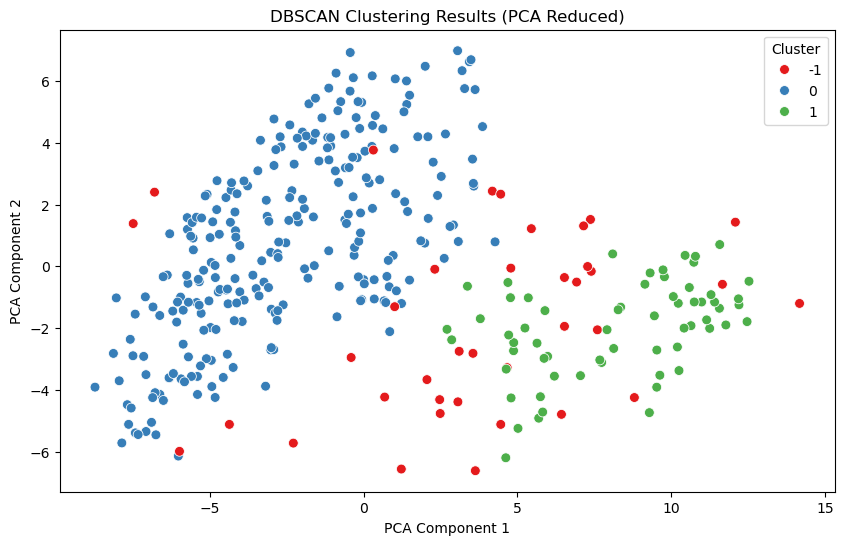

Cluster counts: {-1: 37, 0: 255, 1: 63}


In [24]:
# Set the optimal eps value based on the k-Distance Graph
optimal_eps = best_eps  # Adjust based on the graph
min_samples = best_min_samples  # Keep as is or tune further

# Run DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)  # Ensure X_pca is your PCA-reduced data

# Validate clustering quality
if len(set(dbscan_labels)) > 1:  # Ensure there are at least 2 clusters
    sil_score = silhouette_score(X_pca, dbscan_labels)
    db_score = davies_bouldin_score(X_pca, dbscan_labels)
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")
else:
    print("DBSCAN resulted in only one cluster. Consider adjusting eps or min_samples.")

# Visualize clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='Set1', s=50)
plt.title('DBSCAN Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.savefig("DBSCAN_Reduced1.png", dpi=300, bbox_inches='tight')
plt.show()

# Analyze cluster counts
import numpy as np
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print(f"Cluster counts: {dict(zip(unique_labels, counts))}")

In [25]:
# Ensure you have your DBSCAN labels and the data used for clustering (e.g., X_pca)
if len(set(dbscan_labels)) > 1:  # Ensure there are at least 2 clusters
    # Compute the Silhouette Score
    sil_score = silhouette_score(X_pca, dbscan_labels)  # X_pca is the PCA-reduced data
    print(f"Silhouette Score: {sil_score:.3f}")
    
    # Compute the Davies-Bouldin Index
    db_score = davies_bouldin_score(X_pca, dbscan_labels)
    print(f"Davies-Bouldin Index: {db_score:.3f}")
else:
    print("DBSCAN resulted in only one cluster. Metrics cannot be computed.")

Silhouette Score: 0.331
Davies-Bouldin Index: 1.645


##### PCA=4

Explained Variance Retained: 0.80


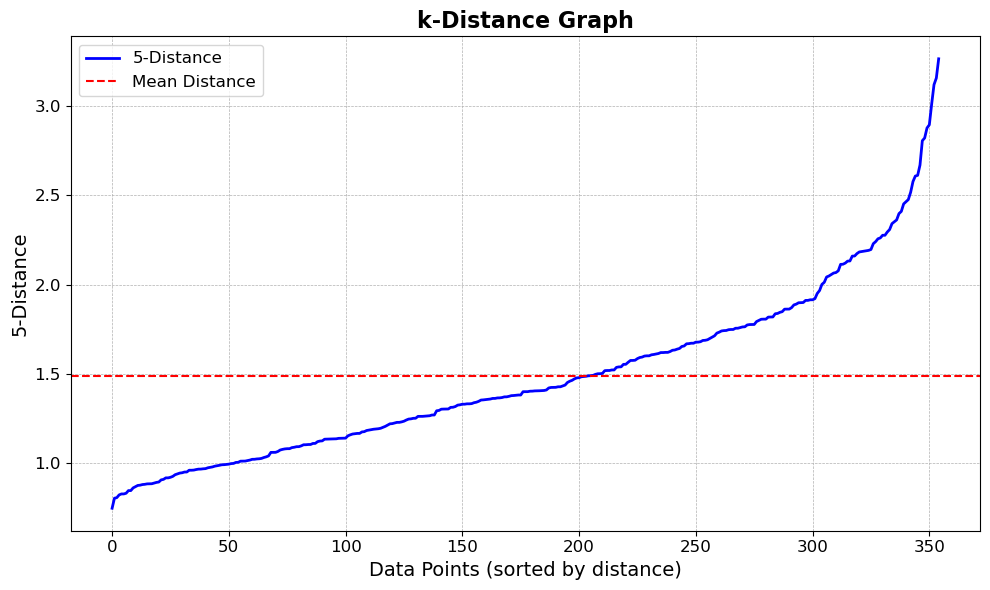

In [26]:
# Reduce dimensions to retain sufficient variance
pca = PCA(n_components=4)  # Adjust based on explained variance
X_pca = pca.fit_transform(X_selected)

# Check the retained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance Retained: {explained_variance:.2f}")
plot_knn(X_pca, k = 5)

In [27]:
# Define the PCA-reduced dataset for Model 2
# Assuming X_pca is already defined (from your PCA step for Model 2)

# Define ranges for eps and min_samples
eps_values = np.arange(1, 5, 0.5)  # Adjust based on your k-Distance graph for X_pca
min_samples_values = range(3, 10)  # Reasonable range for min_samples

# Initialize variables to store the best parameters and score
best_eps = None
best_min_samples = None
best_score = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)  # Use PCA-reduced data
        
        # Skip if only one cluster is formed
        if len(set(labels)) <= 1:
            continue
        
        # Calculate silhouette score
        score = silhouette_score(X_pca, labels)
        if score > best_score:
            best_eps = eps
            best_min_samples = min_samples
            best_score = score

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score:.3f}")

Best eps: 2.0, Best min_samples: 9, Best Silhouette Score: 0.296


Silhouette Score: 0.296
Davies-Bouldin Index: 2.203


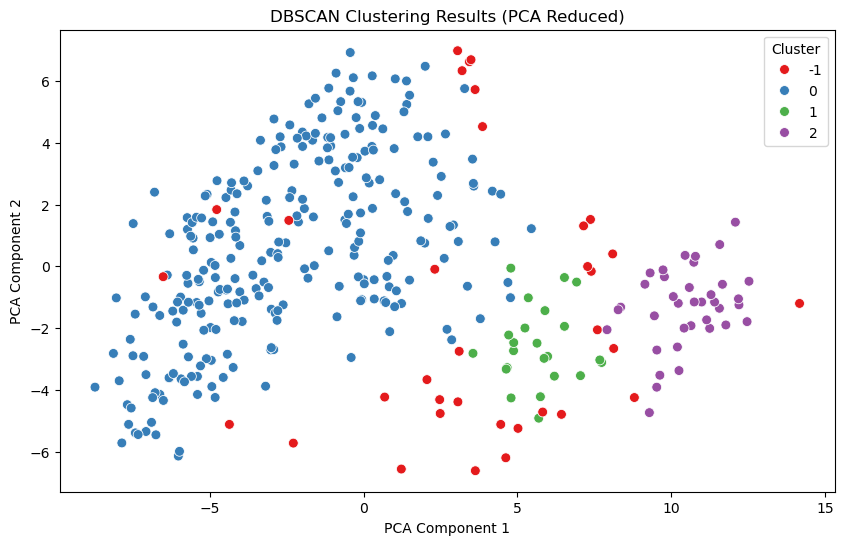

Cluster counts: {-1: 34, 0: 261, 1: 23, 2: 37}


In [28]:
# Set the optimal eps value based on the k-Distance Graph
optimal_eps = best_eps  # Adjust based on the graph
min_samples = best_min_samples  # Keep as is or tune further

# Run DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)  # Ensure X_pca is your PCA-reduced data

# Validate clustering quality
if len(set(dbscan_labels)) > 1:  # Ensure there are at least 2 clusters
    sil_score = silhouette_score(X_pca, dbscan_labels)
    db_score = davies_bouldin_score(X_pca, dbscan_labels)
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")
else:
    print("DBSCAN resulted in only one cluster. Consider adjusting eps or min_samples.")

# Visualize clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='Set1', s=50)
plt.title('DBSCAN Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.savefig("DBSCAN_Reduced2.png", dpi=300, bbox_inches='tight')
plt.show()

# Analyze cluster counts
import numpy as np
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print(f"Cluster counts: {dict(zip(unique_labels, counts))}")

In [29]:
# Ensure you have your DBSCAN labels and the data used for clustering (e.g., X_pca)
if len(set(dbscan_labels)) > 1:  # Ensure there are at least 2 clusters
    # Compute the Silhouette Score
    sil_score = silhouette_score(X_pca, dbscan_labels)  # X_pca is the PCA-reduced data
    print(f"Silhouette Score: {sil_score:.3f}")
    
    # Compute the Davies-Bouldin Index
    db_score = davies_bouldin_score(X_pca, dbscan_labels)
    print(f"Davies-Bouldin Index: {db_score:.3f}")
else:
    print("DBSCAN resulted in only one cluster. Metrics cannot be computed.")

Silhouette Score: 0.296
Davies-Bouldin Index: 2.203


### Summary of PCA With Feature Selection

#### **Clustering Results**
- PCA was applied to the dataset after selecting the top 50 features via `SelectKBest`.
- Clustering using DBSCAN was performed on the reduced dataset (with three components).
- **Silhouette Score**: 0.331

- The silhouette score shows **improved clustering quality** compared to the initial model but is still relatively low.
- **Number of Clusters**:
- DBSCAN identified more clusters compared to the initial model, but some points remained labeled as noise.

#### **Analysis**
- The feature selection step improved clustering performance slightly, as reflected in the higher silhouette score (0.331 vs. 0.271).
- However, the clustering results still indicate **room for improvement**, as the silhouette score suggests that the clusters are not highly well-separated.
- Even after feature selection, PCA may not fully capture the complex non-linear structures in the data, limiting the clustering algorithm's effectiveness.


# Dimensionality reduction using t-SNE - FINAL MODEL

In [30]:
df = pd.read_csv('../data/CIT_full.csv')
df_classes = pd.read_csv('../data/CIT_classes.csv')
df_gene_expression = df.transpose()


df_gene_expression.columns = df_gene_expression.iloc[0]  # Set the first row as column headers
df_transposed = df_gene_expression.drop(df_gene_expression.index[0]) 
df_classes=df_classes.rename(columns={"Unnamed: 0	":"sample_id","x":"target"})
df_transposed=df_transposed.rename(columns={"Unnamed: 0	":"sample_id"})

# Merge expression data and class labels
df = df_transposed.merge(df_classes, left_index=True, right_on='Unnamed: 0')

# Define the feature columns and target column
X = df.drop(['Unnamed: 0', 'target'], axis=1)  # Features (expression data)
y = df['target']  # Target labels

# Perform the stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Check the class distribution in train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
target
normL    0.245847
lumB     0.186047
lumA     0.172757
basL     0.149502
lumC     0.136213
mApo     0.109635
Name: proportion, dtype: float64
Test set class distribution:
target
normL    0.259259
lumB     0.185185
lumA     0.166667
basL     0.148148
lumC     0.129630
mApo     0.111111
Name: proportion, dtype: float64


In [31]:
# Assuming `X` is your dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the scaled data
print("Scaled Data Shape:", X_scaled.shape)

Scaled Data Shape: (355, 20824)


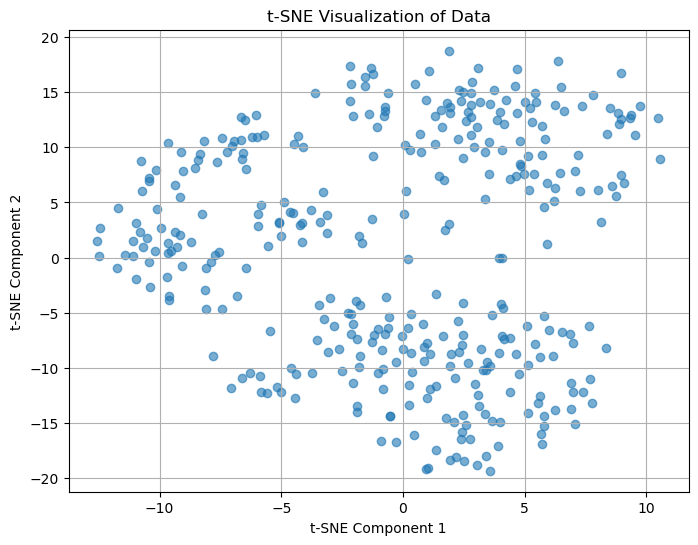

In [32]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Adjust perplexity as needed
X_tsne = tsne.fit_transform(X_scaled)

# Visualize the t-SNE output
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()

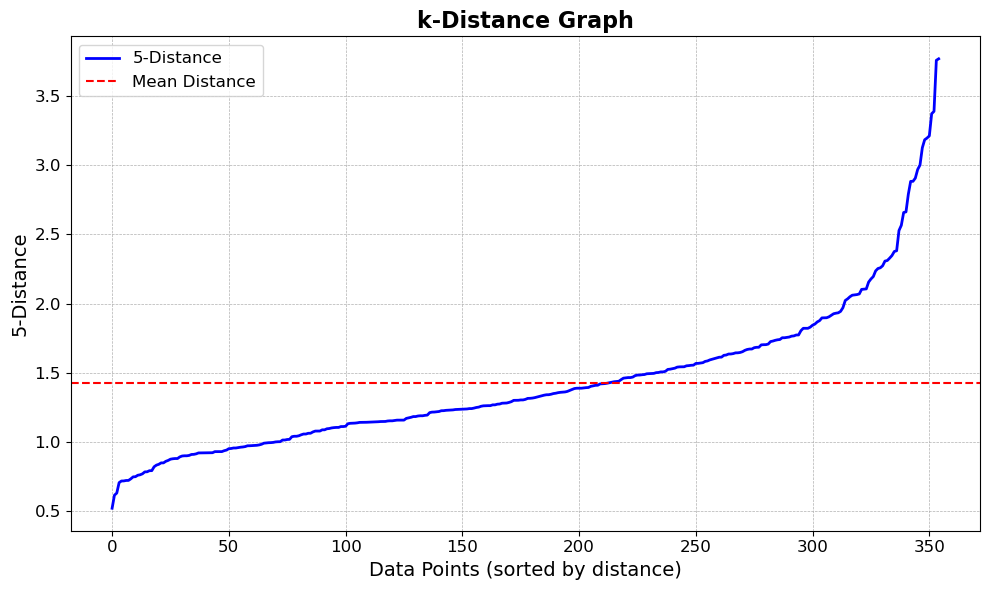

In [33]:
plot_knn(X_tsne, k = 5)

#### Grid Search for Optimal Parameters

In [34]:
# Define ranges for DBSCAN parameters
eps_values = np.arange(2.0, 10.0, 0.5)  # Adjust based on the k-distance graph
min_samples_values = range(3, 10)

# Initialize variables to store the best parameters and scores
best_eps = None
best_min_samples = None
best_score = -1

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_tsne)

        # Skip if only one cluster is formed
        if len(set(labels)) <= 1:
            continue

        # Calculate silhouette score
        score = silhouette_score(X_tsne, labels)
        if score > best_score:
            best_eps = eps
            best_min_samples = min_samples
            best_score = score

# Print the best parameters and silhouette score
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_score:.3f}")


Best eps: 2.0
Best min_samples: 8
Best Silhouette Score: 0.440


In [35]:
# Validate clustering quality
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(X_tsne)

if len(set(labels)) > 1:  # Ensure at least two clusters are formed
    sil_score = silhouette_score(X_tsne, labels)
    db_score = davies_bouldin_score(X_tsne, labels)
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")
else:
    print("DBSCAN resulted in only one cluster. Metrics cannot be computed.")

Silhouette Score: 0.440
Davies-Bouldin Index: 1.212


## Clustering results

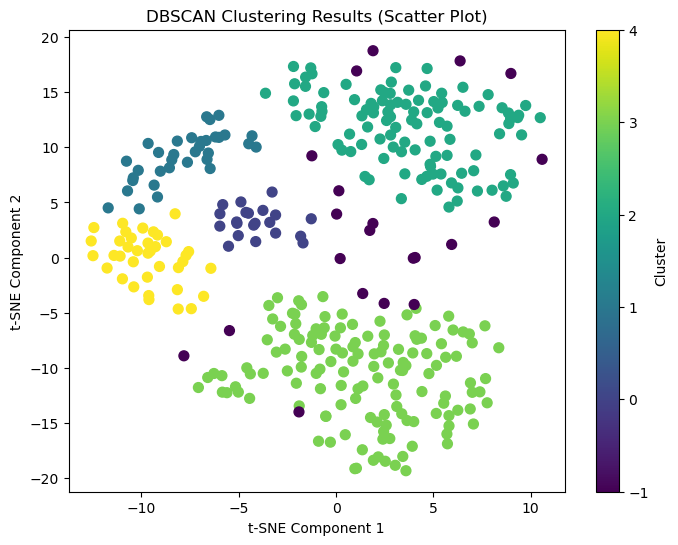

In [36]:
# Visualize DBSCAN clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
plt.title("DBSCAN Clustering Results (Scatter Plot)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster")
plt.savefig("DBSCAN_2.png", dpi=300, bbox_inches='tight')
plt.show()


# **Summary of t-SNE Results**

## **Clustering Quality**
1. **Silhouette Score**: 0.440

- The silhouette score for DBSCAN on the t-SNE-reduced data is significantly higher than for the PCA initial model (0.271) and PCA with feature selection (0.331).
- This indicates better-defined clusters with improved separation.

2. **Number of Clusters**:
- DBSCAN identified a higher number of meaningful clusters using t-SNE compared to the PCA models.
- The clusters were more distinct, and fewer points were labeled as noise (`-1`).

3. **Visualization**:
- t-SNE provided a **2D scatter plot** that visually showed well-separated and compact clusters.
- The improved visualization highlights t-SNE's ability to preserve local data structures and uncover hidden patterns.

---

# **Why t-SNE Was Better Than PCA Models**

1. **Capturing Non-Linear Relationships**:
- PCA is a **linear dimensionality reduction technique**, which struggles to capture the complex, non-linear relationships in high-dimensional datasets like gene expression data.
- t-SNE, a **non-linear technique**, excels at preserving local neighborhood structures and revealing underlying patterns in the data.

2. **Higher Silhouette Score**:
- t-SNE achieved a **higher silhouette score (0.440)** compared to PCA initial (0.271) and PCA with feature selection (0.331), reflecting better cluster compactness and separation.

3. **More Informative Clusters**:
- t-SNE revealed more meaningful and distinct clusters compared to PCA models, uncovering subtle substructures that PCA could not detect.
- Fewer points were labeled as noise, improving the quality of the clustering.

4. **Dimensionality Flexibility**:
- t-SNE is designed to directly project data into 2D space, making it ideal for visual analysis.
- PCA requires iterative adjustments of the number of components, which can miss critical structures in the data.

5. **Improved Clustering Results**:
- DBSCAN on t-SNE-reduced data resulted in better-defined clusters, fewer outliers, and more meaningful insights.

---

# **Conclusion**
The t-SNE model outperformed both PCA models due to:
- A higher silhouette score (0.440 vs. 0.271 and 0.331).
- More distinct clusters and fewer outliers.
- Better visualization that aids interpretation.

By effectively capturing non-linear structures in the data, t-SNE proved to be the **most suitable dimensionality reduction technique** for this dataset, resulting in improved clustering and analysis quality.


Target Distribution Across Clusters:
target   basL  lumA  lumB  lumC  mApo  normL
Cluster                                     
-1          8     1     5     1     3      3
 0          0     5    11     0     3      2
 1          0     7     9     4     4     10
 2         16     5     6    21    13     44
 3         29    25    19    19    16     29
 4          0    18    16     3     0      0


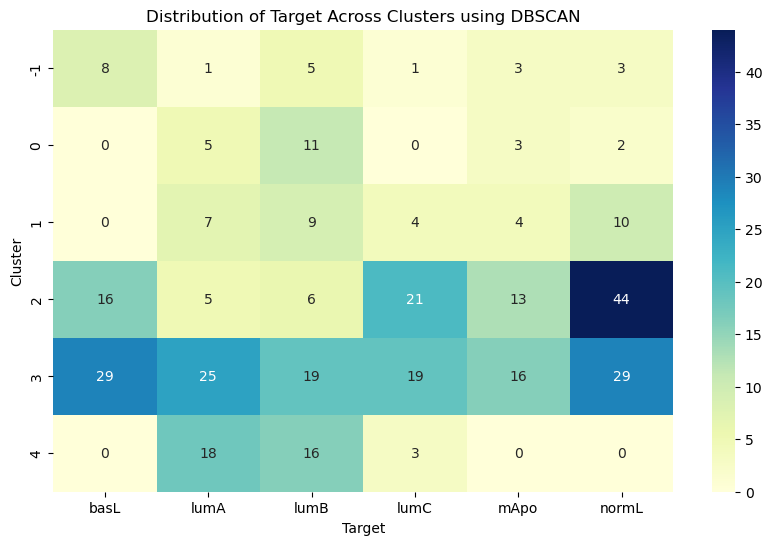

In [37]:
# Assuming your data with cluster labels is stored in a DataFrame called 'df'
# and 'Cluster' column contains the cluster labels from DBSCAN
df['Cluster'] = labels  # Add the cluster labels to the DataFrame

# Calculate the distribution of 'target' within each cluster
target_distribution = pd.crosstab(df['Cluster'], df['target'])

# Print the distribution table
print("Target Distribution Across Clusters:")
print(target_distribution)

# Visualize the distribution as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(target_distribution, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribution of Target Across Clusters using DBSCAN')
plt.ylabel('Cluster')
plt.xlabel('Target')
plt.savefig("DBSCAN_3.png", dpi=300, bbox_inches='tight')
plt.savefig("../results/DBSCAN/class_distribution_DBSCAN.png")
plt.show()

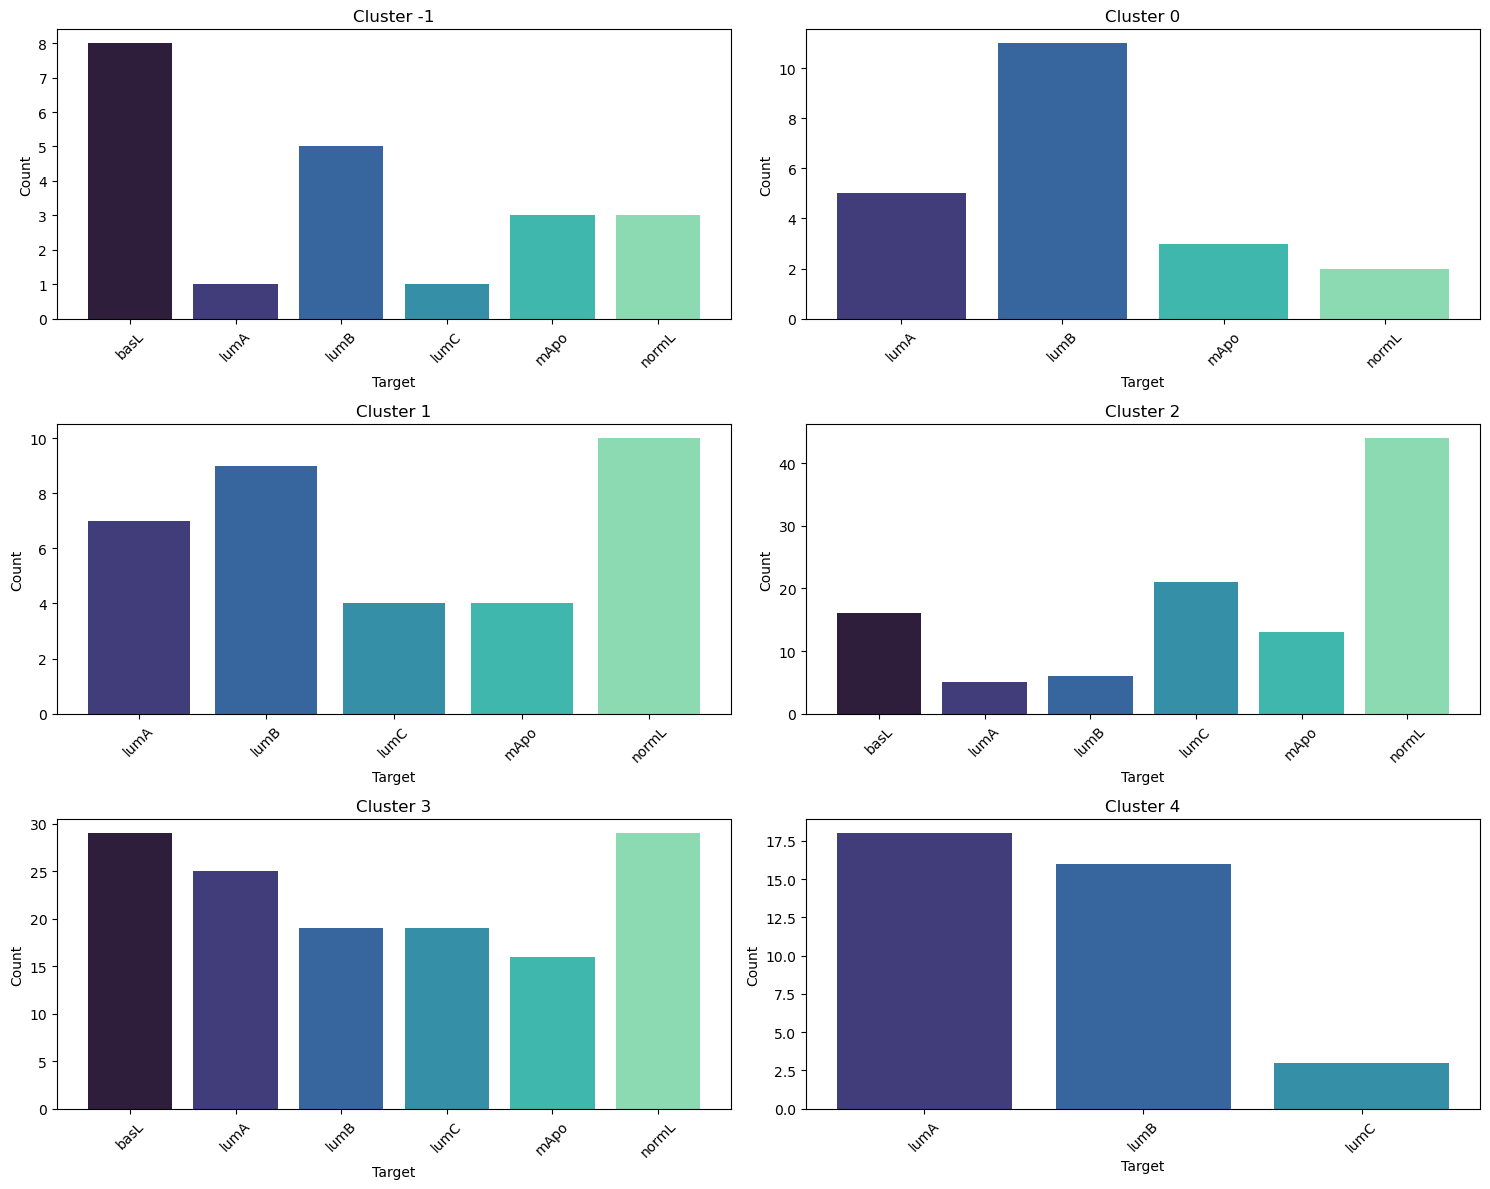

In [38]:
# Assuming `df` contains your data and `labels` is the cluster assignment
df['Cluster'] = labels  # Add the cluster labels to the DataFrame

# Group data by Cluster and Target, count occurrences
target_distribution = df.groupby(['Cluster', 'target']).size().reset_index(name='Count')

# Define a "mako" color palette for the targets
mako_palette = sns.color_palette("mako", n_colors=len(target_distribution['target'].unique()))

# Map target categories to specific shades of the "mako" palette
target_palette = {target: mako_palette[i] for i, target in enumerate(target_distribution['target'].unique())}

# Plot individual bar plots for each cluster in a 3x2 grid
clusters = target_distribution['Cluster'].unique()  # Get unique cluster labels
num_clusters = len(clusters)

# Create a 3x2 grid layout
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, cluster in enumerate(clusters):
    # Filter data for the current cluster
    cluster_data = target_distribution[target_distribution['Cluster'] == cluster]
    
    # Create the bar plot with distinct shades of the "mako" palette for targets
    axes[i].bar(
        cluster_data['target'], 
        cluster_data['Count'], 
        color=[target_palette[t] for t in cluster_data['target']]  # Map mako shades to targets
    )
    axes[i].set_title(f'Cluster {cluster}', fontsize=12)
    axes[i].set_xlabel('Target', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots if clusters < 6
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig("DBSCAN_4.png", dpi=300, bbox_inches='tight')

plt.show()

In [39]:
# Train Random Forest on the original features to predict cluster labels
rf = RandomForestClassifier(random_state=42)
rf.fit(X, labels)  # Replace ⁠ labels ⁠ with ⁠ hierarchical_labels ⁠ if using hierarchical clustering

# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Features by Random Forest Importance:")
print(feature_importances.head(20))

feature_importances.to_csv("../results/DBSCAN/feature_importance_DBSCAN.csv", index=False)

Top 10 Features by Random Forest Importance:
            Feature  Importance
7211           SNCA    0.017022
1042      LOC340107    0.011291
10000           DDC    0.011170
2614   LOC101929450    0.010821
3929           NKTR    0.010772
2311       TMEM151B    0.008139
10562           MAG    0.007630
2195           CALY    0.006951
14526         CCAR1    0.006761
2124        FAM170A    0.006671
7444          P2RX3    0.006591
14304      SECISBP2    0.006463
9370           TPT1    0.006391
17042        GALNT9    0.006357
2157   LOC101929680    0.006089
19965          CASR    0.005911
2509          OR5L2    0.005883
6643         NDUFB1    0.005877
255            TAC4    0.005397
1468   LOC105376323    0.005385


### Analysis of Target Distribution Across Clusters

## **Observations from Clustering**
1. **Cluster -1 (Noise):**
   - Contains 21 points considered as noise.
   - Distributed across several `target` categories, with the largest being `basL` (8 points).

2. **Cluster 0:**
   - Contains 21 points.
   - Dominated by `lumB` (11 points), with small contributions from other targets.

3. **Cluster 1:**
   - Contains 34 points and shows a relatively balanced distribution.
   - Slightly higher representation of `normL`.

4. **Cluster 2:**
   - Largest cluster with 105 points.
   - Primarily dominated by `normL` (44 points) and `mApo` (21 points).

5. **Cluster 3:**
   - Second largest cluster with 137 points.
   - Diverse mix of `basL`, `lumA`, `lumB`, and `normL`.

6. **Cluster 4:**
   - Contains 37 points, dominated by `lumA` (18 points) and `lumB` (16 points).

---

# Hierarchical clustering 

## PCA

In [40]:
## Loading data:
df=pd.read_csv("../data/CIT_full.csv")
df_classes=pd.read_csv("../data/CIT_classes.csv")

df_clust = df.copy()

columns_names = df_clust['Unnamed: 0'].to_numpy()
df_clust.drop(columns='Unnamed: 0', inplace=True)
df_clust = df_clust.T
df_clust = df_clust.set_axis(columns_names, axis=1)

# data standarization
df_clust = (df_clust - df_clust.mean()) / df_clust.std()


# Check contribution of first 10 components
pca_fit_10, exp_variance , _ , _= apply_pca(df_clust)



# We keep the first 7 cause they are the ones explaining most of the variance
pca_fit_7, exp_variance7, p_components, loadings = apply_pca(X = df_clust, n_components = 7)

# PCA dataframe
pca_colnames = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
pca_df = pd.DataFrame(data = p_components, columns = pca_colnames)
#pca_df.to_csv("../../data/pca_df.csv")

# Hierarichal clustering:
n_samples, ln_matrix = hierarchical_clustering(pca_df = pca_df)



tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(df_clust)


##  TSNE

In [41]:
n_samples = X_tsne.shape[0]
distance_matrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(i + 1, n_samples):
        distance_matrix[i, j] = np.linalg.norm([X_tsne[i], X_tsne[j]])
        distance_matrix[j, i] = distance_matrix[i, j]

Z = linkage(X_tsne, method='ward', metric='euclidean')

## Results

### Results PCA

Explained variance ratio: [0.13057615 0.08611945 0.05500402 0.04890873 0.03795748 0.02293464
 0.02001854 0.01755111 0.01522055 0.01251269]


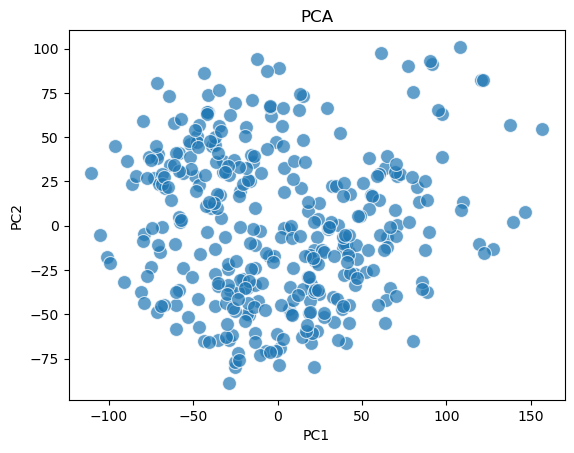

Silhouette score: 0.180
Davies-Bouldin Index: 1.599


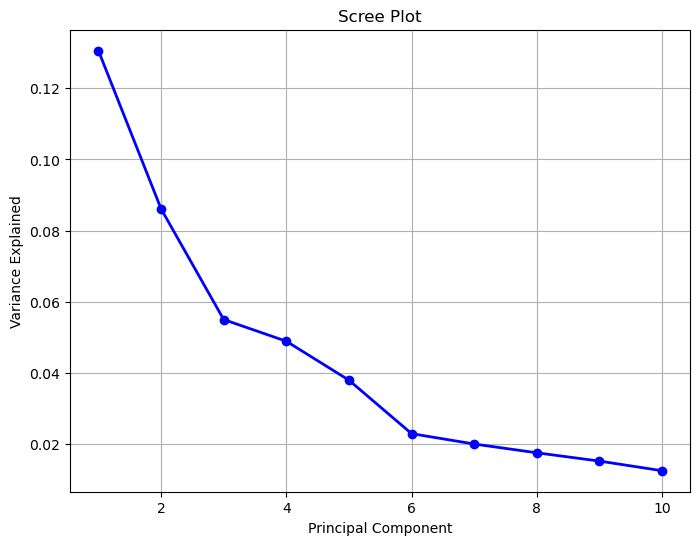

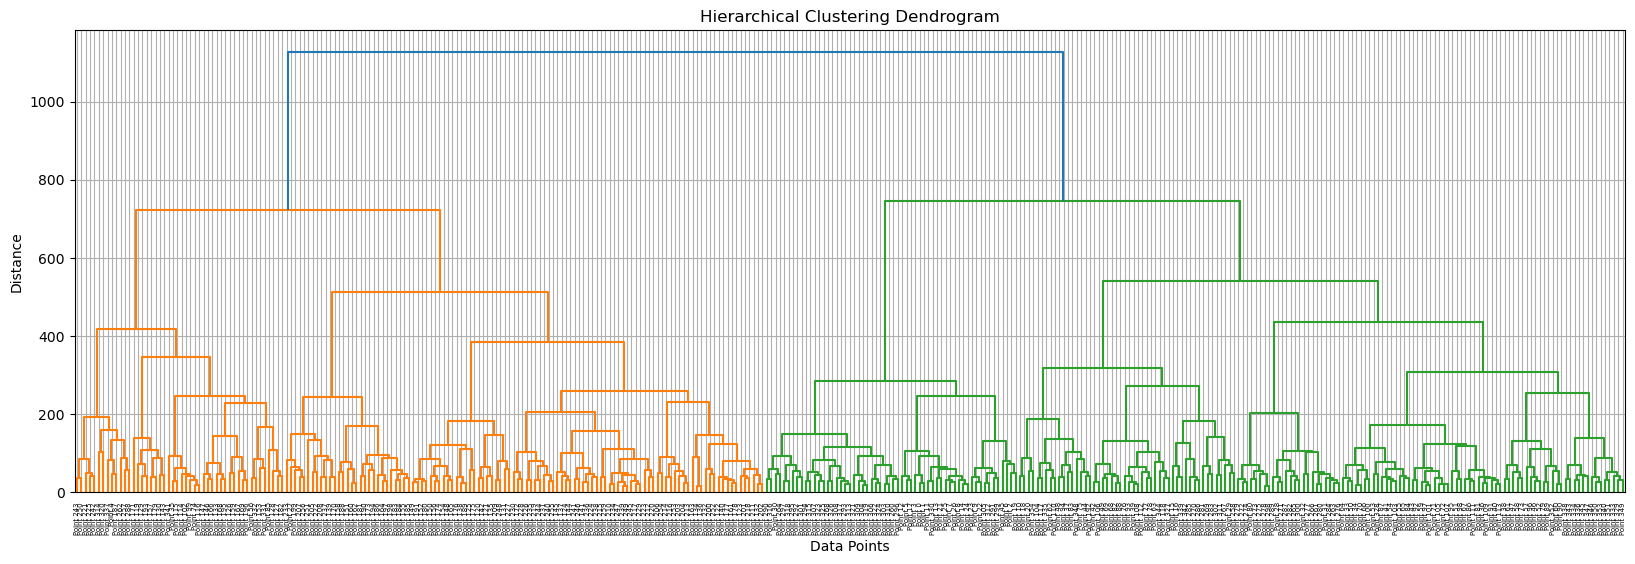

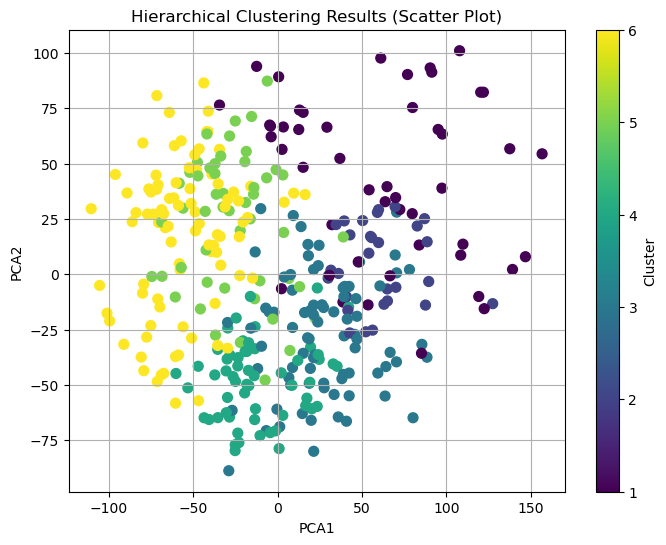

In [42]:
#Explained variance
print(f"Explained variance ratio: {exp_variance}")

#Scatter plot
pca = PCA(n_components=7)
principal_components = pca.fit_transform(df_clust)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])

sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA')
plt.show()

#Scree plot of 10 pC
plot_scree(pca_fit_10)
plot_dendogram(n_samples = n_samples, linkage_matrix = ln_matrix)



X, clulabels = plot_cluster_results(pca_df=pca_df, linkage_matrix=ln_matrix)

s_score = silhouette_score(X, clulabels)
print(f"Silhouette score: {s_score:.3f}")
db_score = davies_bouldin_score(X, clulabels)
print(f"Davies-Bouldin Index: {db_score:.3f}")

### Results TSNE

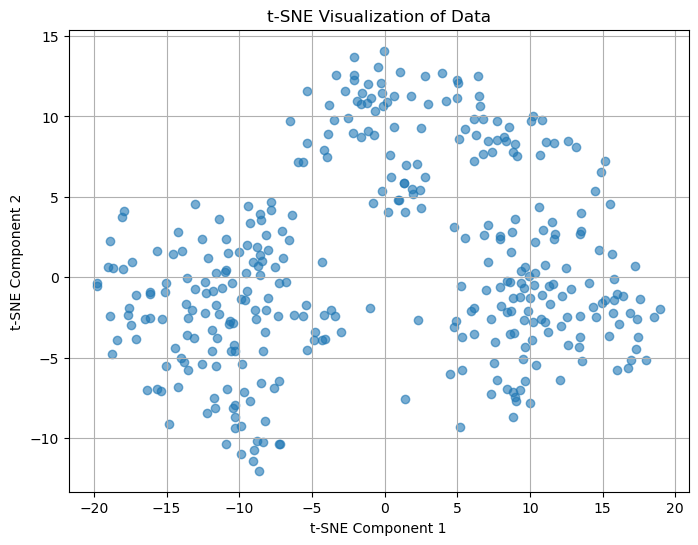

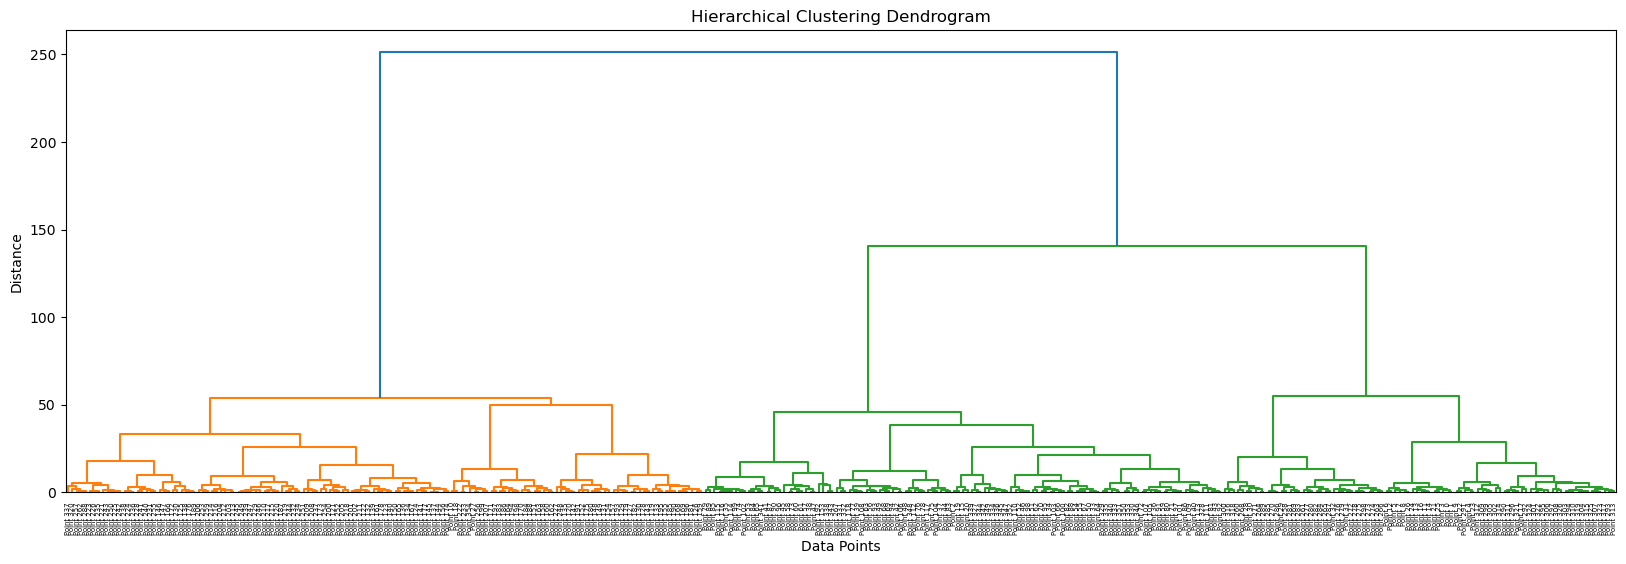

In [43]:
#Plot Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(df_clust)
Z = linkage(X_tsne, method='ward', metric='euclidean')
cluster_labels = fcluster(Z, 6, criterion='maxclust')

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()

# Plot Dendogram
plt.figure(figsize=(20, 6))
sch.dendrogram(Z, labels=[f"Point {i}" for i in range(n_samples)])
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [44]:
# silhouette score
s_score = silhouette_score(X_tsne, cluster_labels)

db_score = davies_bouldin_score(X_tsne, cluster_labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Silhouette score: {s_score:.3f}")

Davies-Bouldin Index: 0.771
Silhouette score: 0.420


### Cluster interpretation:

In [45]:
df_clust2 = df_clust.copy()
df_clust2 = df_clust2.merge(df_classes, left_index=True, right_on='Unnamed: 0')
df_clust2.drop(columns='Unnamed: 0', inplace=True)
df_clust2.rename(columns={'x' : 'class'}, inplace=True)
df_clust2

,PAX8,ESRRA,SCARB1,TTLL12,ADAM32,PRR22,TIMD4,SLC39A5,ATP6V1E2,AFG3L1P,...,LOC100505915,CX3CL1,NPEPL1,ADAP1,LRCH4,MEX3D,EPS8L1,BCAN,DCAF15,class
0,-2.211029,0.409214,0.814886,0.809691,1.228792,-0.271332,-0.981308,-1.050941,1.002358,-1.090946,...,-1.743831,0.371851,-1.851344,1.233160,-1.829575,0.855354,0.330357,-1.522742,0.831067,normL
1,1.377985,1.328529,0.661289,-0.069397,-0.948236,0.463857,-0.121794,0.185019,-2.043884,-0.410160,...,-1.517785,-0.466571,-1.438854,0.170755,-0.626168,1.729424,1.785676,-1.899554,1.719946,lumA
2,0.243543,2.196710,0.579005,0.684729,0.078448,0.398069,0.243986,0.223552,0.608932,-0.832744,...,-1.391692,-0.207650,0.266741,-1.498402,0.006609,0.816154,-1.315773,-0.101924,0.141677,mApo
3,-0.959591,1.408870,0.438173,0.466759,0.050629,0.312837,-0.633765,-0.352342,1.991259,-1.415347,...,-0.908430,-0.117288,-2.153552,0.989327,-0.694712,1.404812,0.456222,-1.877271,0.577985,lumA
4,0.528041,-0.325573,-0.011990,0.995476,2.365325,-0.309821,0.760803,0.877008,-0.137309,-1.168191,...,-1.513661,-1.013758,1.495498,0.796040,-0.669696,0.155746,-0.665773,0.335441,-0.241339,lumB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,-1.699746,-1.897281,0.272356,2.174308,-0.088839,-1.151100,-0.601827,0.277367,-0.947867,0.223255,...,-1.214408,-0.123228,-0.498528,1.168303,-0.812083,0.916034,0.335884,-0.577270,0.828801,normL
351,0.440102,-0.426560,-0.505411,0.229291,-0.399630,-0.410553,-1.586851,0.455809,-0.140935,0.174686,...,0.354857,0.140969,-0.710538,0.587454,-0.160871,0.998070,0.327369,-1.122998,0.938437,normL
352,-1.455789,-0.692258,0.192386,0.712040,2.724431,-2.078274,-0.696044,-2.107597,-0.600941,0.004498,...,-0.238665,-0.858200,-0.454047,-1.289529,-1.071742,-0.314802,0.730742,-0.665987,-0.489983,normL
353,-1.276530,-0.721974,0.020686,0.756822,-1.103528,-0.159889,-1.129565,0.885921,0.962447,-0.152787,...,-1.365640,0.198037,-0.989323,0.233951,-1.278788,0.907604,0.155114,-0.121680,0.482613,normL


Target Distribution Across Clusters:
class    basL  lumA  lumB  lumC  mApo  normL
cluster                                     
1           1    23    11    18     4     31
2          24     0     0     0     0      0
3           8     2    11     1    12      0
4          20     7     8    21    18     45
5           0     8     9     5     5     10
6           0    21    27     3     0      2


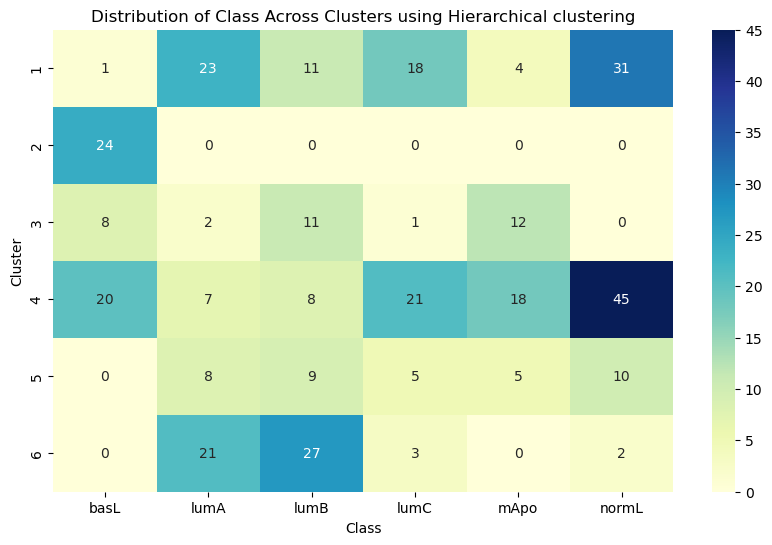

In [46]:
df_clust2['cluster'] = cluster_labels 

class_distribution = pd.crosstab(df_clust2['cluster'], df_clust2['class'])

print("Target Distribution Across Clusters:")
print(class_distribution)

plt.figure(figsize=(10, 6))
sns.heatmap(class_distribution, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribution of Class Across Clusters using Hierarchical clustering')
plt.ylabel('Cluster')
plt.xlabel('Class')
plt.savefig("../results/hierarchical_clustering/class_distribution_hierarch.png")
plt.show()

In [47]:
rf = RandomForestClassifier(random_state=42)
rf.fit(df_clust, cluster_labels)

feature_importances = pd.DataFrame({
    'Feature': df_clust.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 20 Features by Random Forest Importance:")
print(feature_importances.head(20))

feature_importances.to_csv("../results/hierarchical_clustering/feature_importance_hierarchical.csv", index=False)


Top 20 Features by Random Forest Importance:
               Feature  Importance
7211              SNCA    0.010694
10127           PKD1P6    0.009195
9370              TPT1    0.008160
10000              DDC    0.007398
3929              NKTR    0.007363
14526            CCAR1    0.006987
2614      LOC101929450    0.006914
8461             RBBP4    0.006280
2157      LOC101929680    0.006273
13384            THOC2    0.005919
2311          TMEM151B    0.005626
10562              MAG    0.005448
2195              CALY    0.005256
3263            CAPZA2    0.005207
2856   RPL9 /// RPL9P7    0.004912
10601            HNF4A    0.004747
2434             AGAP4    0.004651
13761          TMEM14C    0.004537
1042         LOC340107    0.004514
6643            NDUFB1    0.004403


# GMM

In [48]:
#Load Data
cit_classes = pd.read_csv('../data/CIT_classes.csv', index_col=0)
cit_full = pd.read_csv('../data/CIT_full.csv', index_col=0)

In [49]:
aligned_full = cit_full[cit_classes.index]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(aligned_full.T)

variances = np.var(scaled_data, axis=0)
top_genes_idx = np.argsort(variances)[-500:]  # Get indices of top 500 most variable genes
selected_data = scaled_data[:, top_genes_idx]

pca = PCA(n_components=50)
data_pca = pca.fit_transform(selected_data)
print(aligned_full)

        CIT_DSOA_440  CIT_DSOA_439  CIT_DSOA_467  CIT_DSOA_452  CIT_DSOA_466  \
PAX8        6.717509      7.740125      7.416889      7.074081      7.497951   
ESRRA       7.225762      7.563684      7.882810      7.593216      6.955669   
SCARB1      8.669086      8.566631      8.511745      8.417805      8.117529   
TTLL12      9.040389      8.336170      8.940284      8.765673      9.189218   
ADAM32      4.181571      3.427750      3.783251      3.773619      4.575109   
...              ...           ...           ...           ...           ...   
LRCH4       7.168097      7.554989      7.758425      7.532952      7.540995   
MEX3D       7.463022      8.203230      7.429826      7.928331      6.870559   
EPS8L1      8.188810      9.256133      6.981547      8.281119      7.458253   
BCAN        6.538719      6.446201      6.887572      6.451672      6.994959   
DCAF15      6.743969      7.165872      6.416753      6.623845      6.234956   

        CIT_DSOA_448  CIT_DSOA_447  CIT

In [50]:
gmm = GaussianMixture(n_components=6, random_state=42)  # 6 clusters based on example classes
gmm_labels = gmm.fit_predict(data_pca)

true_labels = cit_classes.iloc[:, 0]  # True class labels
ari_gmm = adjusted_rand_score(true_labels, gmm_labels)
nmi_gmm = normalized_mutual_info_score(true_labels, gmm_labels)

## Results results of GMM

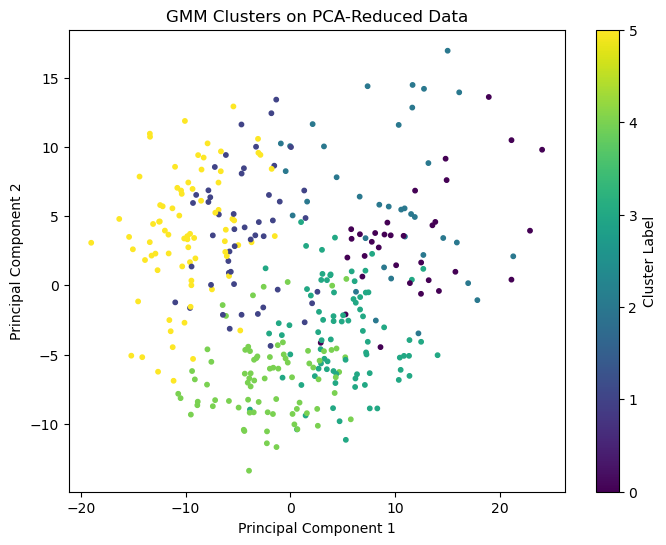

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.colorbar(label='Cluster Label')
plt.title('GMM Clusters on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

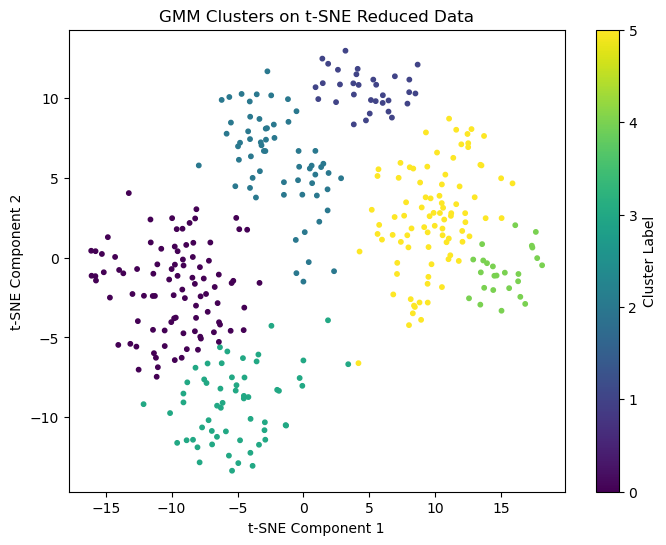

In [52]:
tsne = TSNE(n_components=2, perplexity=30,  random_state=42)
data_tsne = tsne.fit_transform(selected_data)

gmm = GaussianMixture(n_components=6, random_state=42)  # 6 clusters based on example classes
gmm_labels = gmm.fit_predict(data_tsne)

true_labels = cit_classes.iloc[:, 0]  # True class labels
ari_gmm = adjusted_rand_score(true_labels, gmm_labels)
nmi_gmm = normalized_mutual_info_score(true_labels, gmm_labels)


plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.colorbar(label='Cluster Label')
plt.title('GMM Clusters on t-SNE Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [53]:
print(f"GMM ARI: {ari_gmm}")
print(f"GMM NMI: {nmi_gmm}")

# gmm_silhouette = silhouette_score(data_pca, gmm_labels)
# print(f"GMM Silhouette Score: {gmm_silhouette}")
# gmm_dbi = davies_bouldin_score(data_pca, gmm_labels)
# print(f"GMM Davies-Bouldin Index: {gmm_dbi}")

gmm_silhouette = silhouette_score(data_tsne, gmm_labels)
print(f"GMM Silhouette Score: {gmm_silhouette}")
gmm_dbi = davies_bouldin_score(data_tsne, gmm_labels)
print(f"GMM Davies-Bouldin Index: {gmm_dbi}")

GMM ARI: 0.15137786768148478
GMM NMI: 0.2282926594746038
GMM Silhouette Score: 0.40436872839927673
GMM Davies-Bouldin Index: 0.7997363125374847


class    basL  lumA  lumB  lumC  mApo  normL
cluster                                     
1           1    23    11    18     4     31
2          24     0     0     0     0      0
3           8     2    11     1    12      0
4          20     7     8    21    18     45
5           0     8     9     5     5     10
6           0    21    27     3     0      2


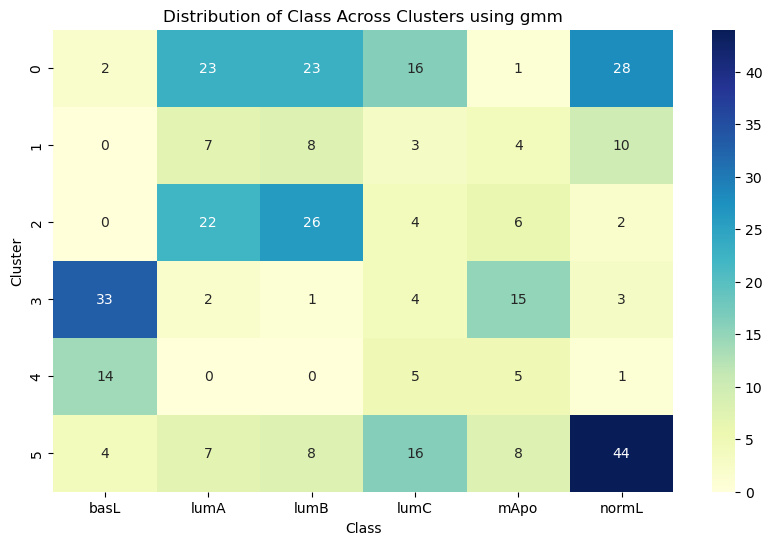

In [54]:

#gmm_labels = gmm.fit_predict(data_tsne)

#true_labels = cit_classes.iloc[:, 0]  # True class labels
#cit_classes
class_distribution_gmm = pd.crosstab(gmm_labels, true_labels)

print(class_distribution)


plt.figure(figsize=(10, 6))
sns.heatmap(class_distribution_gmm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribution of Class Across Clusters using gmm')
plt.ylabel('Cluster')
plt.xlabel('Class')
plt.savefig("../results/GMM/class_ditributions_gmmm.png")
plt.show()


# XGBoost


## Training XGboost

/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [23:23:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 96.30%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        10
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00         6
           5       0.93      1.00      0.97        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54

Accuracy: 96.30%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        10
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00         6
           5       0.93      1.00      0.97        14

    accuracy                           0.96

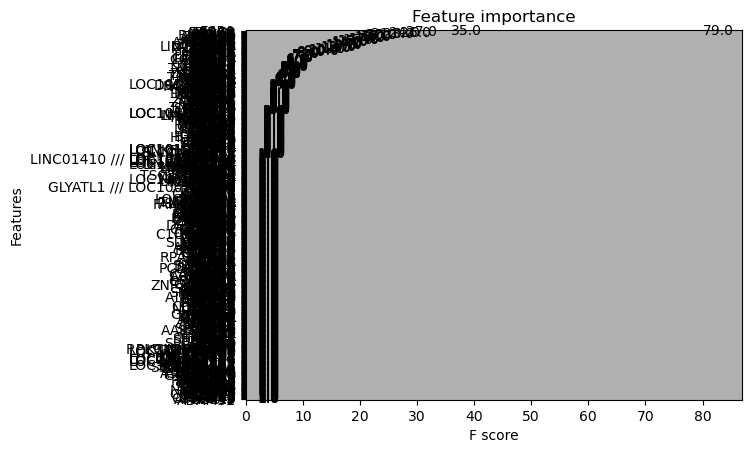

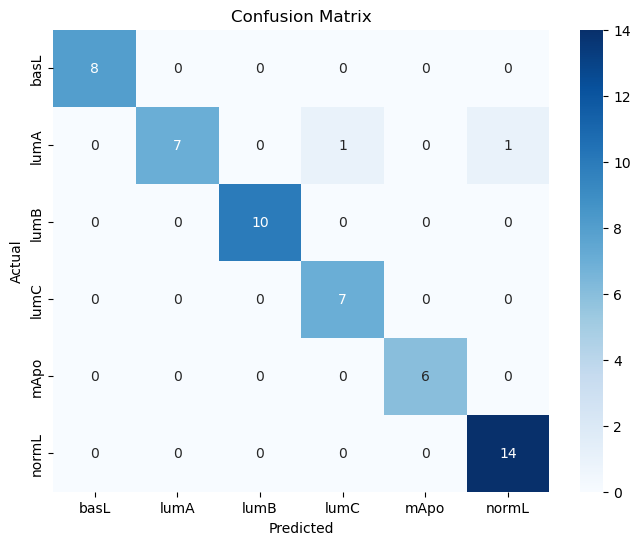

In [ ]:
X_train=pd.read_csv("../data/X_train.csv",index_col="sample_id")
X_test=pd.read_csv("../data/X_test.csv",index_col="sample_id")
y_train=pd.read_csv("../data/y_train.csv",index_col="sample_id")
y_test=pd.read_csv("../data/y_test.csv",index_col="sample_id")

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

clf = xgb.XGBClassifier(
    objective='multi:softmax',   
    num_class=len(encoder.classes_), 
    eval_metric='mlogloss',  
    max_depth=6,  
    learning_rate=0.1, 
    n_estimators=100,  
    silent=1  
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print(classification_report(y_test, y_pred))


# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

class_report = classification_report(y_test, y_pred)
print(class_report)

with open("../results/classification_report_xgb.txt", "w") as file:
    file.write(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_names = list(encoder.classes_)  

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("../results/confusion_matrix_xgb.png")

## Feature importance

In [56]:
# Feature importance
gain_importance = clf.get_booster().get_score(importance_type='gain')
weight_importance = clf.get_booster().get_score(importance_type='weight')

features = X_train.columns
gain_importance = {f: gain_importance.get(f, 0) for f in features}
weight_importance = {f: weight_importance.get(f, 0) for f in features}

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Gain': [gain_importance[f] for f in features],
    'Weight': [weight_importance[f] for f in features]
}).sort_values(by='Gain', ascending=False)

feature_importance_df.to_csv("../results/xgboost/feature_importance_xgb.csv", index=False)



        Feature       Gain  Weight
0         FOXA1  28.049959    23.0
1         CENPA  23.233721    14.0
2     LINC00472  22.002865     1.0
3  LOC101927523  17.855640     1.0
4         HJURP  17.153223    19.0
5          GPD2  17.012730     4.0
6          MLPH  15.881400    11.0
7         H2AFJ  15.386330    24.0
8          MYOF  14.458160     1.0
9        ZNF740  13.320059     1.0


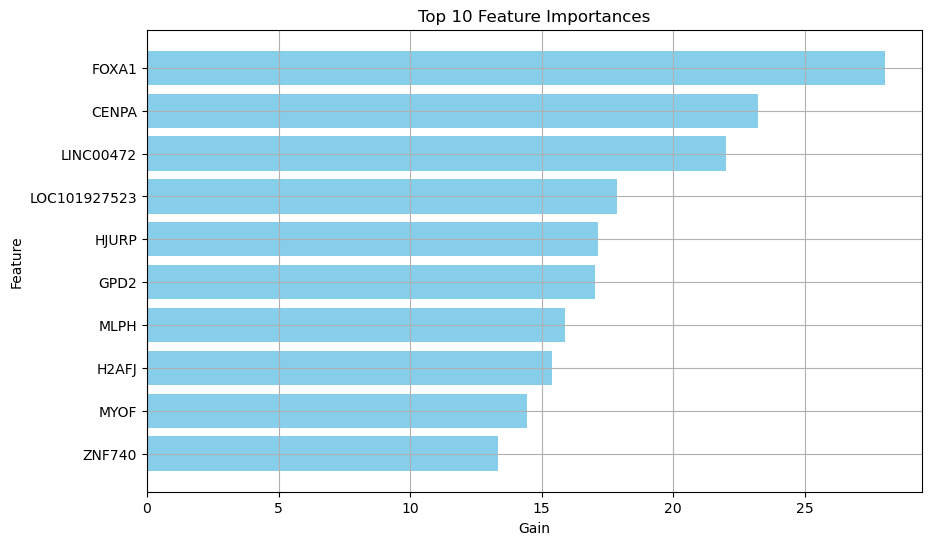

In [ ]:
df = pd.read_csv("../results/xgboost/feature_importance_xgb.csv")

# Sort by Gain and select top 10 features
top_10 = df.nlargest(10, 'Gain')
relevant=df[df["Gain"]>0]
print(top_10)
# Plotting top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10['Feature'], top_10['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig("../results/analysis_plots/top_gain_features.png")


### Plot expression per subtype

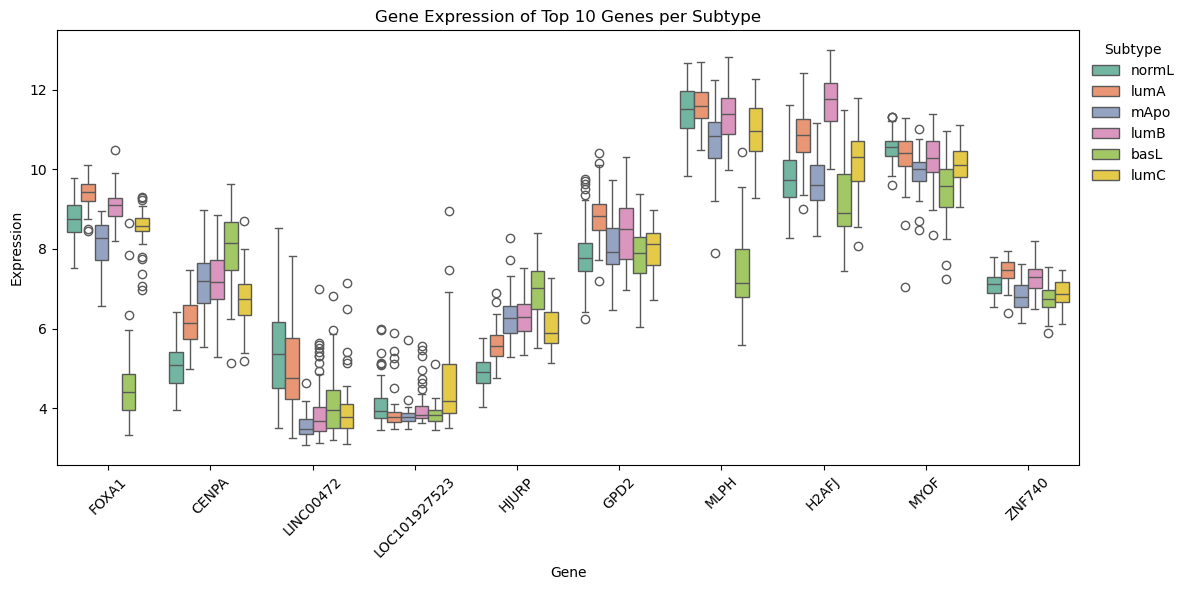

In [ ]:
gene_expression_df=pd.read_csv("../data/CIT_full_cleaned.csv")
gene_expression_df=gene_expression_df.rename(columns={"target":"subtype"})
df = pd.read_csv("../results/xgboost/feature_importance_xgb.csv")

# Sort by Gain and select top 10 features
top_genes = df.nlargest(10, 'Gain')["Feature"].to_list()


# Create a DataFrame for plotting with only the top 10 genes and their corresponding subtypes
top_genes_df = gene_expression_df[['subtype'] + top_genes]

# Melt the DataFrame to make it long-form for easier plotting with seaborn
top_genes_long = pd.melt(top_genes_df, id_vars=['subtype'], value_vars=top_genes, 
                         var_name='gene', value_name='expression')

# Plot gene expression for top 10 genes per subtype
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_genes_long, x='gene', y='expression', hue='subtype', palette='Set2')

# Customize plot
plt.title('Gene Expression of Top 10 Genes per Subtype')
plt.xticks(rotation=45)
plt.xlabel('Gene')
plt.ylabel('Expression')
plt.legend(title='Subtype', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
plt.savefig("../results/analysis_plots/expression.png")


# Frequent item set from XGBoost genes

basL


/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


lumA


/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


lumB


/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


lumC


/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


mApo


/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


normL


/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent itemsets for subtype basL:
        support                             itemsets
0      0.830189                             (FRMD4A)
1      0.792453                             (KLHL21)
2      0.754717                             (CEP170)
3      0.679245                              (CPEB3)
4      0.679245                              (SOCS5)
...         ...                                  ...
18212  0.113208           (ZNF205-AS1, TPM2, CEP170)
18213  0.113208          (KLHL21, ZNF205-AS1, MLLT3)
18214  0.113208          (ZNF205-AS1, RHBDF2, MLLT3)
18215  0.113208  (KLHL21, ZNF205-AS1, RHBDF2, MLLT3)
18216  0.113208      (ZNF205-AS1, PROSER3, PCDHGA11)

[18217 rows x 2 columns]


Frequent itemsets for subtype lumA:
        support                                           itemsets
0      0.836066                                            (MLLT3)
1      0.819672                                       (ZNF205-AS1)
2      0.819672                                           (MRPL

/var/folders/sr/ct0s8yks2xj208z3j8z3rbx40000gn/T/ipykernel_31879/1660735751.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subtype", y="Frequent Itemset Count", data=subtype_counts_df, palette="viridis")


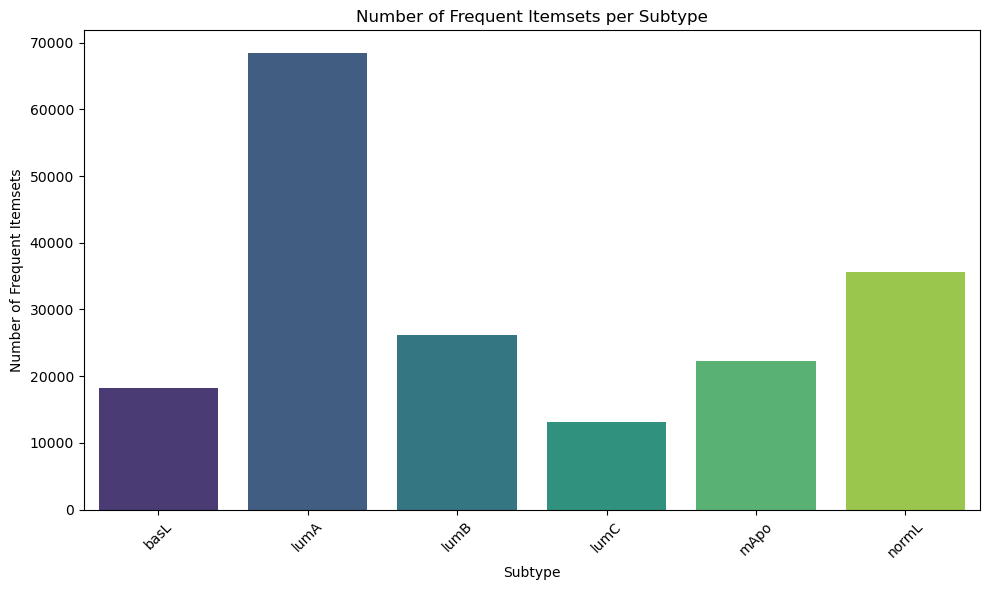

In [ ]:
subtypes=pd.read_csv("../data/CIT_classes_cleaned.csv")
top_genes=pd.read_csv("../results/xgboost/feature_importance_xgb.csv")

df = pd.read_csv("../data/CIT_full_cleaned.csv")  
df_merge=pd.merge(df,subtypes,on="sample_id")

filtered_top_genes=top_genes[top_genes["Gain"]>0]
sorted_filtered_genes=filtered_top_genes.sort_values(by="Gain")[0:30]["Feature"].to_list()
sorted_filtered_genes_w_subtype=["subtype"]+sorted_filtered_genes

data=df_merge[sorted_filtered_genes_w_subtype]

threshold = data[sorted_filtered_genes].median(axis=0)  # Median expression for each gene

binary_data = data.copy()  
binary_data[sorted_filtered_genes] = data[sorted_filtered_genes].gt(threshold, axis=1).astype(int)

subtype_groups = binary_data.groupby("subtype")

frequent_itemsets_by_subtype = {}

for subtype, group in subtype_groups:
    print(subtype)

    gene_data = group.drop(columns=["subtype"])
    
    frequent_itemsets = fpgrowth(gene_data, min_support=0.1, use_colnames=True)
    frequent_itemsets_by_subtype[subtype] = frequent_itemsets
    frequent_itemsets_sorted=frequent_itemsets.sort_values(by="support",ascending=False)

    output_file =  f"../results/xgboost/{subtype}_frequent_itemsets.csv"
    frequent_itemsets_sorted.to_csv(output_file, index=False)


# Output results
for subtype, itemsets in frequent_itemsets_by_subtype.items():
    print(f"Frequent itemsets for subtype {subtype}:")
    print(itemsets)
    print("\n")

# Collecting the number of frequent itemsets for each subtype
subtype_counts = {subtype: len(itemsets) for subtype, itemsets in frequent_itemsets_by_subtype.items()}

# Convert to DataFrame for easier plotting with seaborn
subtype_counts_df = pd.DataFrame(list(subtype_counts.items()), columns=["Subtype", "Frequent Itemset Count"])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Subtype", y="Frequent Itemset Count", data=subtype_counts_df, palette="viridis")
plt.title("Number of Frequent Itemsets per Subtype")
plt.xlabel("Subtype")
plt.ylabel("Number of Frequent Itemsets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/xgboost/frequent_items_subtype.png")



/var/folders/sr/ct0s8yks2xj208z3j8z3rbx40000gn/T/ipykernel_31879/2897990984.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['itemsets'] = df_filtered['itemsets'].apply(eval)  # Convert frozenset from string to actual frozenset
/var/folders/sr/ct0s8yks2xj208z3j8z3rbx40000gn/T/ipykernel_31879/2897990984.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['itemsets'] = df_filtered['itemsets'].apply(eval)  # Convert frozenset from string to actual frozenset
/var/folders/sr/ct0s8yks

Unique itemsets for lumB_frequent_itemsets: {frozenset({'CRCP'}), frozenset({'LMBR1'}), frozenset({'MRPL24', 'CRCP'}), frozenset({'MRPL24'}), frozenset({'HSBP1'})}
Unique itemsets for normL_frequent_itemsets: {frozenset({'ZBED3'}), frozenset({'KLHL21'}), frozenset({'ADAMTS15'}), frozenset({'RHOB'}), frozenset({'TPM2'})}
Unique itemsets for lumC_frequent_itemsets: {frozenset({'LGMN'}), frozenset({'GLYATL1 /// LOC100287413'})}
Unique itemsets for basL_frequent_itemsets: {frozenset({'CEP170'}), frozenset({'HLA-B'}), frozenset({'KLHL21'}), frozenset({'FRMD4A', 'RHBDF2'}), frozenset({'FRMD4A'}), frozenset({'RHBDF2'}), frozenset({'RHBDF2', 'KLHL21'})}
Unique itemsets for mApo_frequent_itemsets: {frozenset({'LGMN'})}
Unique itemsets for lumA_frequent_itemsets: {frozenset({'ADAMTS15'}), frozenset({'MRPL24'}), frozenset({'MARC2'}), frozenset({'MLLT3'}), frozenset({'ZNF205-AS1'}), frozenset({'PMF1'}), frozenset({'HSBP1'})}
Unique Itemsets Table:
                   Subtype  Unique Itemsets
0   lu

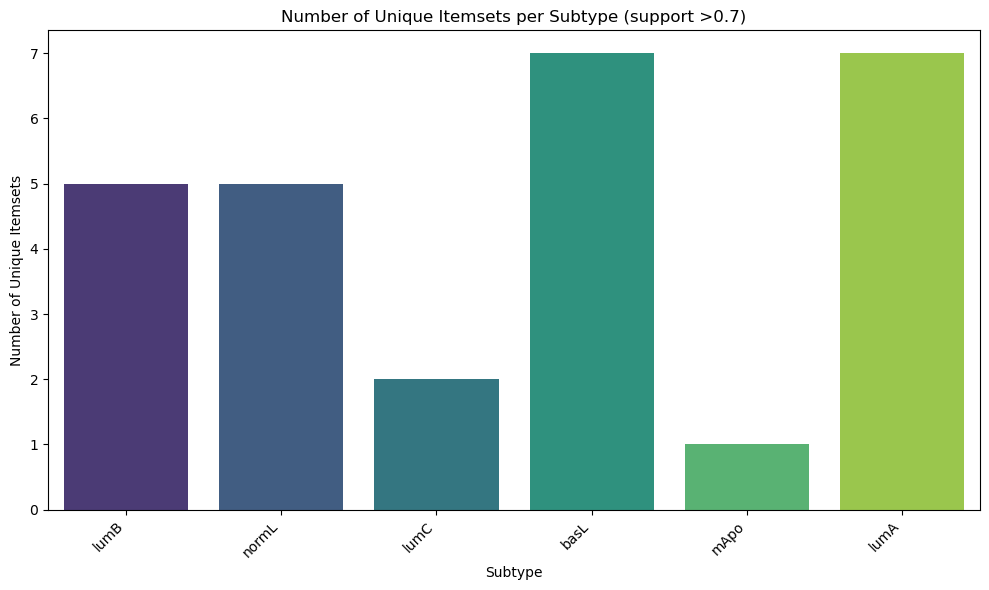

In [ ]:
# Function to read and filter CSV file by support > 0.7
def read_and_filter_csv(file_path):
    df = pd.read_csv(file_path)
    df_filtered = df[df['support'] > 0.7]
    df_filtered['itemsets'] = df_filtered['itemsets'].apply(eval)  # Convert frozenset from string to actual frozenset
    return df_filtered['itemsets'].tolist()

# Function to find unique itemsets for each subtype
def find_unique_itemsets(itemsets_by_subtype):
    all_itemsets = set()  # To track all itemsets across all subtypes
    unique_itemsets = defaultdict(set)  # Dictionary to store unique itemsets for each subtype
    
    # Collect all itemsets across subtypes
    for subtype, itemsets in itemsets_by_subtype.items():
        all_itemsets.update(itemsets)
    
    # Identify unique itemsets for each subtype
    for subtype, itemsets in itemsets_by_subtype.items():
        # Unique itemsets for this subtype (those that are not in other subtypes)
        unique_itemsets[subtype] = set(itemsets) - (all_itemsets - set(itemsets))
    
    return unique_itemsets

# Directory where your CSV files are located
folder_path = '../results/xgboost/'  # Change to your folder path

# Read and process each CSV file
itemsets_by_subtype = {}
for file_name in os.listdir(folder_path):
    if file_name.endswith('itemsets.csv'):
        subtype = file_name.split('.')[0]  # Assuming the file name is the subtype name
        file_path = os.path.join(folder_path, file_name)
        itemsets_by_subtype[subtype] = read_and_filter_csv(file_path)

# Find unique itemsets for each subtype
unique_itemsets = find_unique_itemsets(itemsets_by_subtype)

# Print results
for subtype, unique_sets in unique_itemsets.items():
    print(f"Unique itemsets for {subtype}: {unique_sets}")
# Find unique itemsets for each subtype
unique_itemsets = find_unique_itemsets(itemsets_by_subtype)

# Create a DataFrame to display the results as a table
unique_items_table = pd.DataFrame({
    'Subtype': list(unique_itemsets.keys()),
    'Unique Itemsets': [len(itemsets) for itemsets in unique_itemsets.values()]
})

# Display the table
print("Unique Itemsets Table:")
print(unique_items_table)
unique_items_table["Subtype"] = unique_items_table["Subtype"].apply(lambda x: x.split("_")[0])
# Plot the number of unique itemsets for each subtype
plt.figure(figsize=(10, 6))
sns.barplot(x="Subtype", y="Unique Itemsets", data=unique_items_table, palette="viridis")

plt.xlabel('Subtype')
plt.ylabel('Number of Unique Itemsets')
plt.title('Number of Unique Itemsets per Subtype (support >0.7)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig("../results/analysis_plots/unique_freq_items.png")

## Heatmaps for frequent sets

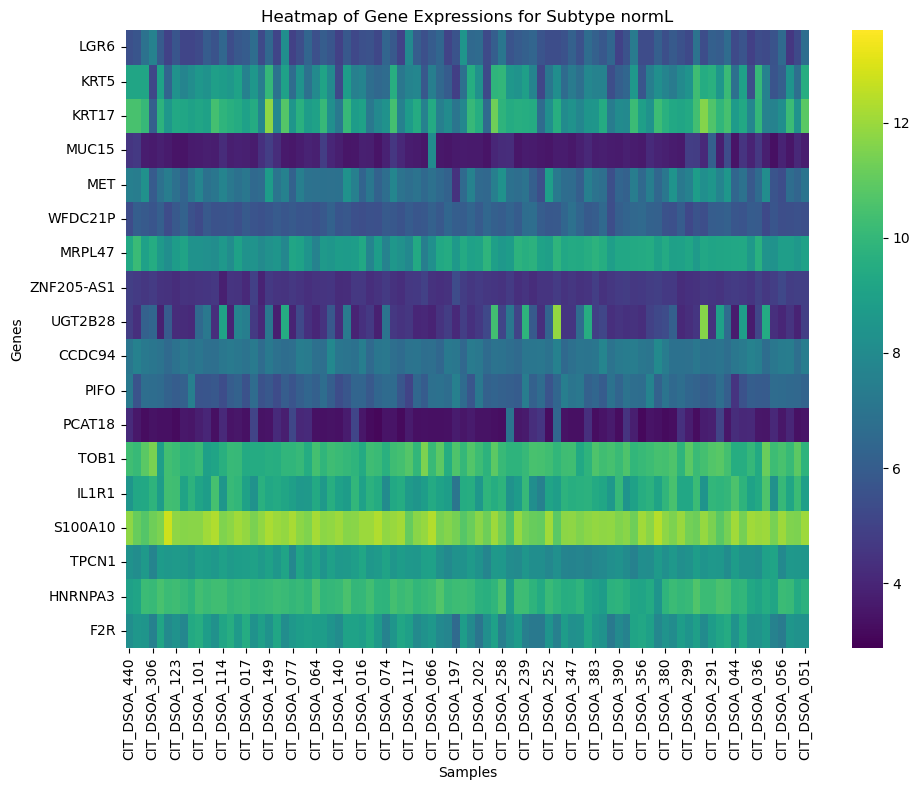

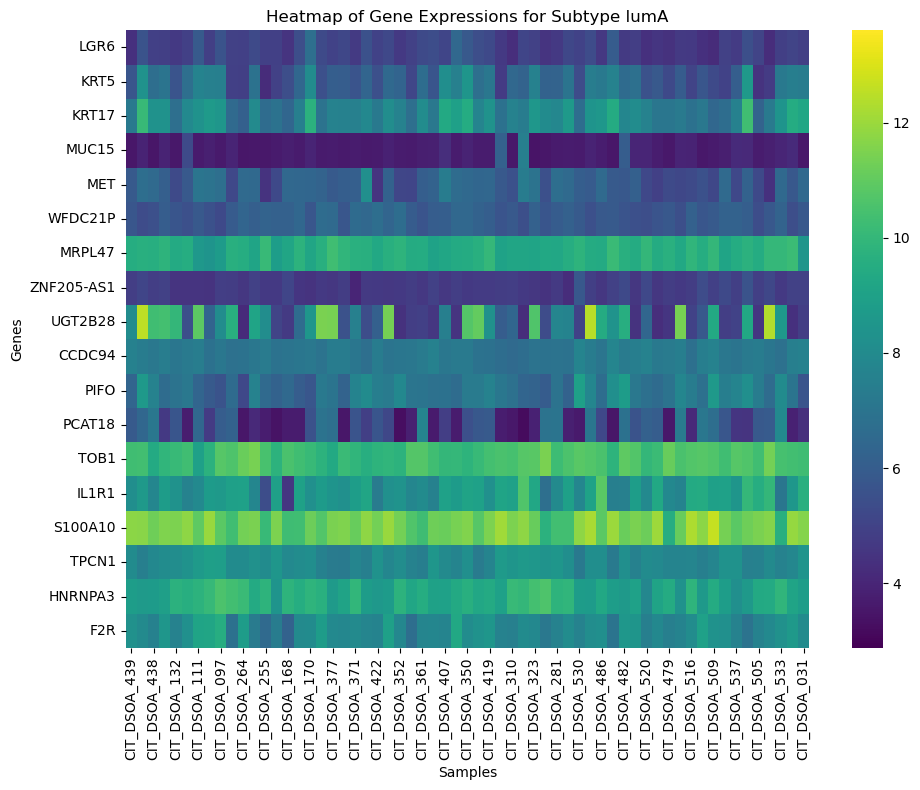

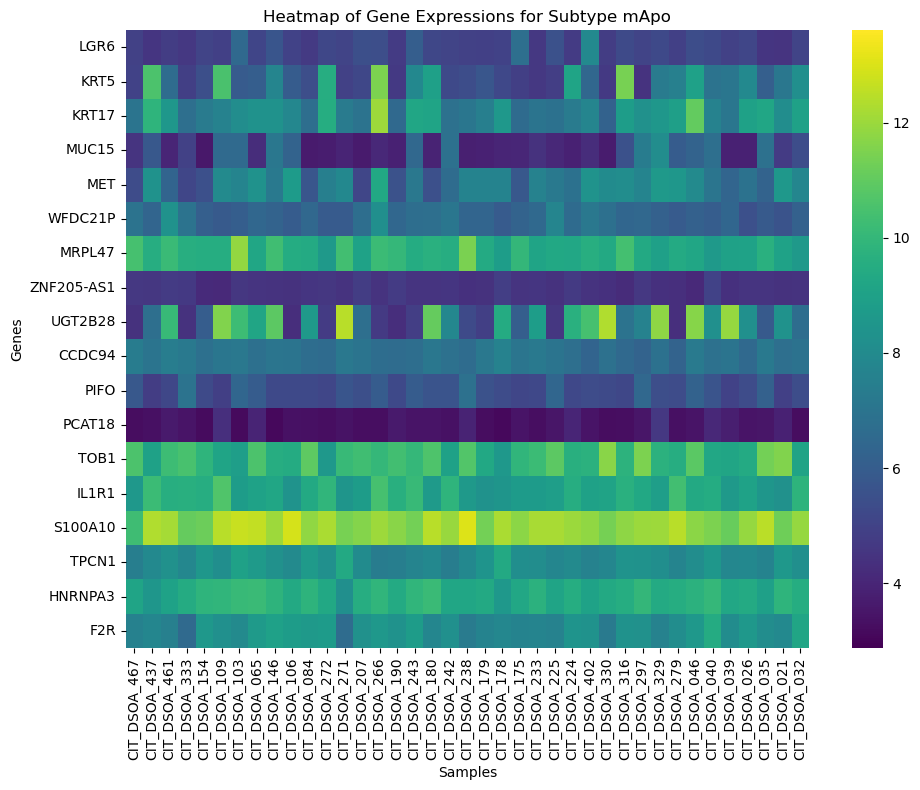

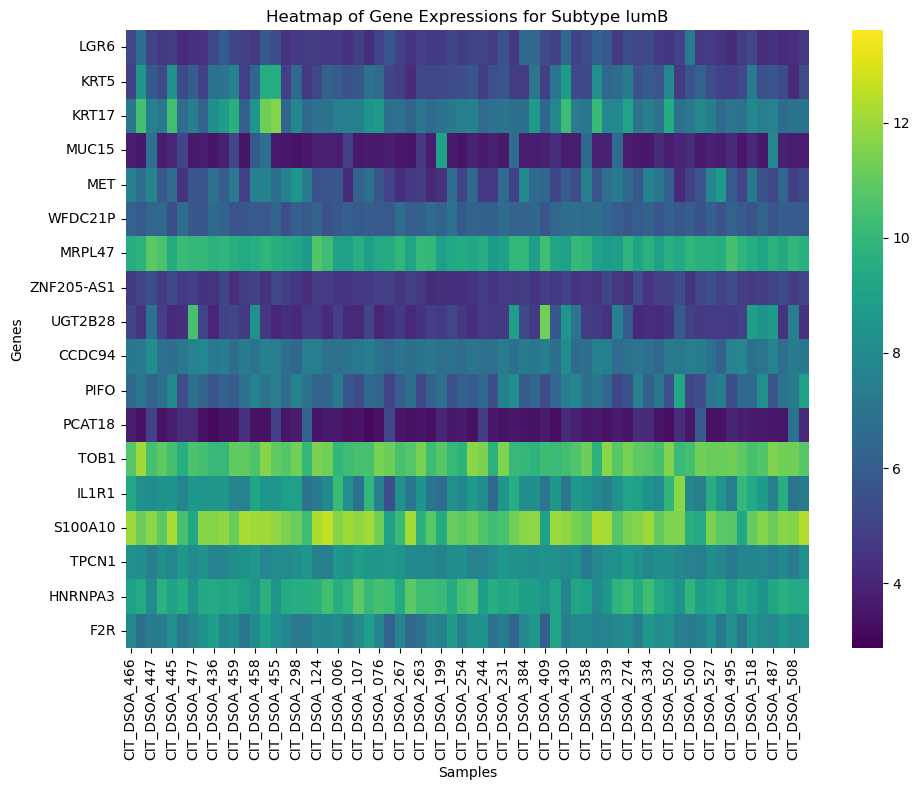

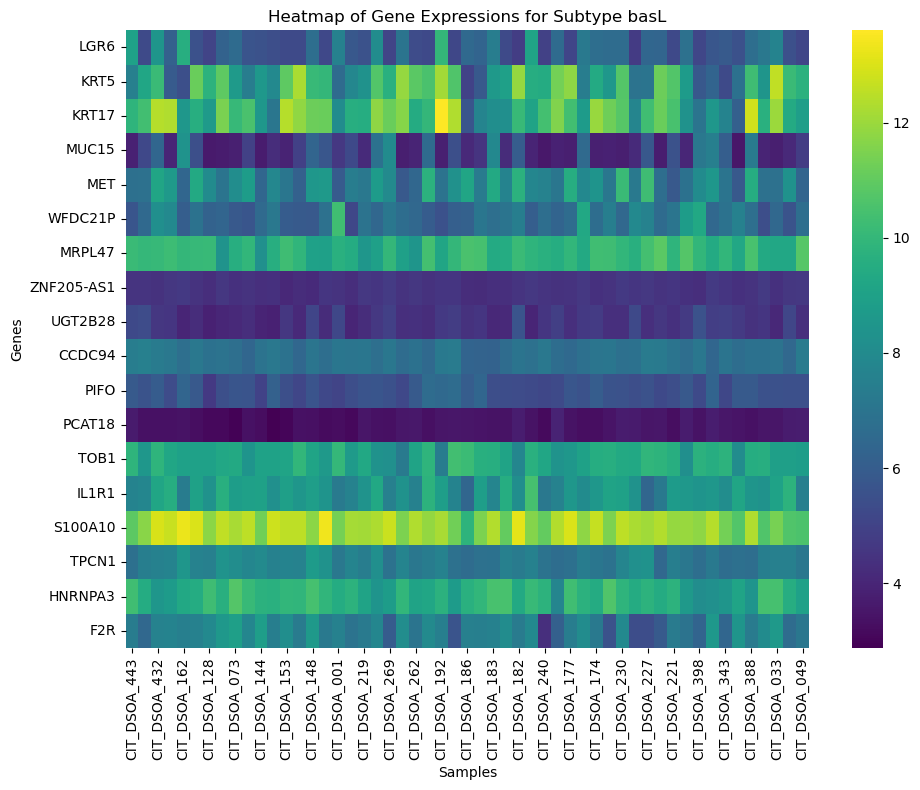

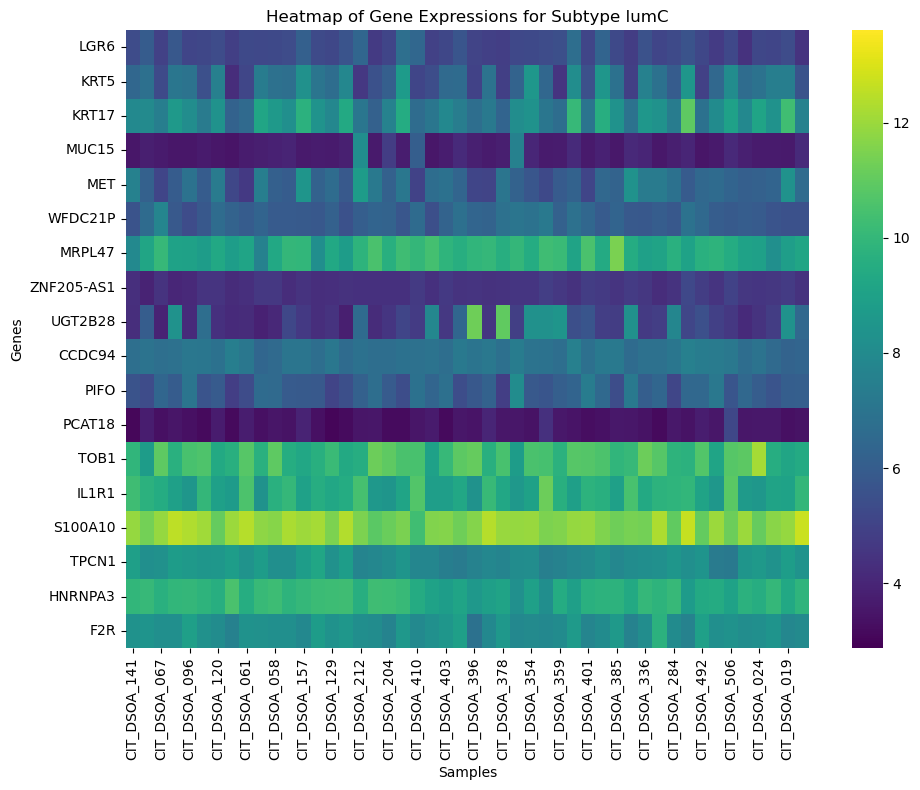

In [ ]:
df=pd.read_csv("../data/CIT_full_cleaned.csv")
df=df.rename(columns={"target":"subtype"})
gene_list= ['LGR6', 'KRT5', 'KRT17', 'MUC15', 'MET', 'WFDC21P', 'MRPL47',
             'ZNF205-AS1', 'UGT2B28', 'CCDC94', 'PIFO', 'PCAT18', 'TOB1', 'IL1R1',
             'S100A10', 'TPCN1', 'HNRNPA3', 'F2R']
# Select the columns needed for the heatmap
gene_list = ["sample_id", "subtype"] + gene_list
df_merged = df[gene_list]

# Set the 'sample' column as the index
df_merged.set_index('sample_id', inplace=True)

# Calculate global min and max for the color scale
gene_data = df_merged.drop(columns=['subtype'])  # Exclude the 'subtype' column
vmin, vmax = gene_data.min().min(), gene_data.max().max()

# Create heatmaps for each subtype
subtypes = df_merged['subtype'].unique()

for subtype in subtypes:
    # Filter the data for the current subtype
    df_subtype = df_merged[df_merged['subtype'] == subtype]
    
    # Drop the 'subtype' column since it's not part of the heatmap
    df_subtype = df_subtype.drop(columns=['subtype'])
    
    # Create the heatmap with consistent color scale
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_subtype.T, cmap="viridis", cbar=True, annot=False, vmin=vmin, vmax=vmax)
    plt.title(f"Heatmap of Gene Expressions for Subtype {subtype}")
    plt.xlabel("Samples")
    plt.ylabel("Genes")
    
    # Show the plot
    plt.tight_layout()

    plt.savefig(f"../results/analysis_plots/boxplot_{subtype}.png")

# Louivan Clustering from XGBoost genes

## Making graphs

In [62]:

# 1. Load important features from xgb_model
features = pd.read_csv('../results/xgboost/feature_importance_xgb.csv')
features = features[(features['Gain'] != 0) & (features['Weight'] != 0)]

# 2. Load the complete dataset
full_df = pd.read_csv('../data/CIT_genes.csv').T

# 3. Filter significant genes from the dataset based on xgb model
sig_genes = list(features['Feature'])
sig_genes_df = full_df.loc[sig_genes]

# 4. Calculate correlation and similarity matrices
pearson_matrix = sig_genes_df.T.corr(method='pearson')
pearson_matrix_df = pd.DataFrame(pearson_matrix, index=sig_genes_df.index, columns=sig_genes_df.index)

cosine_matrix = cosine_similarity(sig_genes_df)
cosine_matrix_df = pd.DataFrame(cosine_matrix, index=sig_genes_df.index, columns=sig_genes_df.index)

# Display correlation and similarity matrices
#print("Cosine Similarity Matrix:")
#print(cosine_matrix_df)
#print("Pearson Correlation Matrix:")
#print(pearson_matrix_df)

# 5. Generate graphs and save them
graph_pearson = nx.from_pandas_adjacency(pearson_matrix_df)
nx.write_graphml(graph_pearson, "../results/graph_clustering/sig_genes_graph_pearson.graphml")

graph_cosine = nx.from_pandas_adjacency(cosine_matrix_df)
nx.write_graphml(graph_cosine, "../results/graph_clustering/sig_genes_graph_pearson.graphml")

## Community clustering

In [63]:

# Step 1: Load the precomputed graphs from the .graphml file
graph_files = ["../results/graph_clustering/sig_genes_graph_pearson.graphml",
               "../results/graph_clustering/sig_genes_graph_cosine.graphml"] # Replace with your .graphml file path

pearson_graph = nx.read_graphml(graph_files[0])
cosine_graph = nx.read_graphml(graph_files[1])

# Step 2: Apply Louvain clustering
print("Running Louvain clustering...")
communities_pearson = nx.community.louvain_communities(pearson_graph, seed=123)  # Seed for reproducibility
communities_cosine = nx.community.louvain_communities(cosine_graph, seed=123)  # Seed for reproducibility

# Step 3: Output the number of communities detected
print(f"Number of communities detected using pearson matrix: {len(communities_pearson)}")
print(f"Number of communities detected using cosine matrix: {len(communities_cosine)}")

# Step 4: Save the communities to a file for later inspection
output_files = ["../results/graph_clustering/sig_louvain_communities_pearson.txt",
                "../results/graph_clustering/sig_louvain_communities_cosine.txt"]

print(f"Saving communities to {output_files[0]}...")

with open(output_files[0], "w") as f:
    for i, community in enumerate(communities_pearson):
        f.write(f"Community {i} ({len(community)} nodes): {', '.join(community)}\n")


print(f"Saving communities to {output_files[1]}...")

with open(output_files[1], "w") as f:
    for i, community in enumerate(communities_cosine):
        f.write(f"Community {i} ({len(community)} nodes): {', '.join(community)}\n")

print("Louvain clustering completed and results saved.")

Running Louvain clustering...
Number of communities detected using pearson matrix: 128
Number of communities detected using cosine matrix: 128
Saving communities to ../results/graph_clustering/sig_louvain_communities_pearson.txt...
Saving communities to ../results/graph_clustering/sig_louvain_communities_cosine.txt...
Louvain clustering completed and results saved.


# Community analysis 

In [ ]:
def parse_communities(file_path):

    communities = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            # Match the pattern for a community line
            match = re.match(r"Community (\d+) \(\d+ nodes\): (.+)", line)
            if match:
                community_id = int(match.group(1))
                nodes = [node.strip() for node in match.group(2).split(",")]
                communities[community_id] = nodes
                
    return communities

def plot_individual_communities(communities,thres):
    for community_id, nodes in communities.items():
        if len(nodes) > thres:  # Only plot communities with more than 2 nodes
            # Create a subgraph for the current community
            G = nx.Graph()
            G.add_nodes_from(nodes)
            for i, node1 in enumerate(nodes):
                for j, node2 in enumerate(nodes):
                    if i != j:
                        G.add_edge(node1, node2)  # Fully connect the community
            
            # Generate a layout
            pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
            
            # Random color for the community
            color = [random.random() for _ in range(3)]
            
            # Plot the community
            plt.figure(figsize=(6, 6))
            nx.draw_networkx_nodes(G, pos, node_size=600, node_color=[color], alpha=0.8)
            nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)
            nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", font_color="black")
            plt.title(f"Community {community_id} (Nodes: {len(nodes)})", fontsize=14)
            plt.axis("off")
            plt.savefig(f"community_{community_id}.png")


def plot_communities(communities):
    G = nx.Graph()

    # Add nodes and edges for communities with more than two nodes
    for community_id, nodes in communities.items():
        if len(nodes) > 2:
            for i, node in enumerate(nodes):
                for j in range(i + 1, len(nodes)):
                    G.add_edge(node, nodes[j])
    
    # Position nodes using spring layout with higher repulsion
    pos = nx.spring_layout(G, seed=42, k=0.6)  # Increase `k` for more separation

    # Generate a color map for communities
    node_colors = {}
    for community_id, nodes in communities.items():
        if len(nodes) > 2:
            color = [random.random() for _ in range(3)]  # Random RGB color
            for node in nodes:
                node_colors[node] = color

    # Extract colors for each node in the graph
    color_list = [node_colors[node] for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color=color_list, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)
    nx.draw_networkx_labels(
        G, pos, font_size=10, font_weight="bold", font_color="black"
    )

    plt.title("Communities with More than 2 Nodes", fontsize=16)
    plt.axis("off")
    plt.show()
def plot_top_go_terms(go_results, community_id):
    """
    Generate a bar plot for the top 10 GO terms based on p-value for a community.
    
    Args:
        go_results (DataFrame): The GO enrichment results.
        community_id (int): The community ID.
    """
    # Sort by p-value and select the top 10
    top_go = go_results.sort_values(by='p_value').head(10)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_go['name'], -np.log10(top_go['p_value']), color='skyblue')
    plt.xlabel('-log10(p-value)')
    plt.title(f"Top 10 GO Terms for Community {community_id}")
    plt.gca().invert_yaxis()  # Invert y-axis to display the top term at the top
    plt.tight_layout()
    plt.savefig(f"community_{community_id}_top_go_terms.png")
    plt.close()
def perform_go_analysis(communities, threshold=4):
    """
    Perform GO enrichment analysis on communities with more than `threshold` nodes.
    """
    gp = GProfiler(return_dataframe=True)

    for community_id, nodes in communities.items():
        if len(nodes) > threshold:  # Only analyze communities with more than `threshold` nodes
            # Assuming `nodes` represent the gene list or feature names for GO analysis
            relevant = pd.DataFrame({'Feature': nodes})
            
            # Perform GO analysis
            results = gp.profile(
                organism='hsapiens',  # Human species, you can change to other species
                query=relevant['Feature'].tolist()
            )
            print(f"GO Analysis for Community {community_id}:")
            print(results.columns)
            
            # Save the results to a CSV
            results.to_csv(f"../results/analysis_plots/community_{community_id}_go_analysis.csv", index=False)
            plot_top_go_terms(results, community_id)

file_path = "../results/graph_clustering/sig_louvain_cosine_communities.txt"  # Replace with your actual file path
communities = parse_communities(file_path)

#plot_individual_communities(communities,4)

perform_go_analysis(communities, threshold=4)  # Perform GO analysis for communities with more than 4 nodes


GO Analysis for Community 2:
Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')
GO Analysis for Community 6:
Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')
GO Analysis for Community 9:
Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')
GO Analysis for Community 28:
Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', '

# Final Analysis

/Users/codito/miniforge3/envs/ml/lib/python3.8/site-packages/upsetplot/plotting.py:15: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


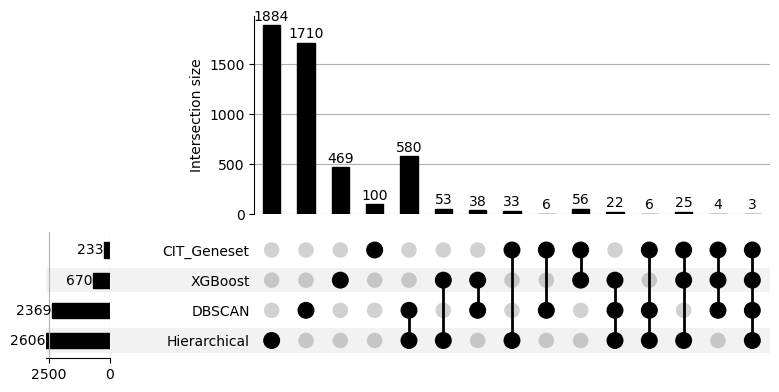

In [ ]:
df=pd.read_csv("../data/CIT_subtyping.csv")

df_genes_subtyping=df["Unnamed: 0"].to_list()
with open("CIT_genes_subtyping.txt","w") as file:
    for i in df_genes_subtyping:
        file.write(i+"\n")
    file.close()

# Load data
df_xgb = pd.read_csv("../results/xgboost/feature_importance_xgb.csv")
df_dbscan = pd.read_csv("../results/DBSCAN/feature_importance_DBSCAN.csv")
df_hierar = pd.read_csv("../results/hierarchical_clustering/feature_importance_hierarchical.csv")

# Extract genes based on thresholds
genes_xgb = df_xgb[df_xgb["Gain"] > 0]["Feature"].to_list()
genes_dbscan = df_dbscan[df_dbscan["Importance"] > 0]["Feature"].to_list()
genes_hierar = df_hierar[df_hierar["Importance"] > 0]["Feature"].to_list()


dict_set = {
    'XGBoost': set(genes_xgb),
    'DBSCAN': set(genes_dbscan),
    'Hierarchical': set(genes_hierar),
    'CIT_Geneset': set(df_genes_subtyping)
}

example = from_contents(dict_set)
plot(example, show_counts='%d')
plt.savefig('upset_plot.png')